In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.colors import LogNorm, rgb2hex
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams['font.size'] = 18
plt.rc('legend',fontsize=14)
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['figure.figsize'] = [6, 3.5]
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.linewidth'] = 1.2

from utils.utils import *
from utils.utils_synthetic import create_network
import utils.HTC_utils as HTC
import utils.dyngdim.dyngdim as dyngdim
from utils.dyngdim.plotting import compute_dim_max, plot_results

import random
from PIL import Image

import networkx as nx

import seaborn as sns
import starbars
from pingouin import partial_corr
#from statannotations.Annotator import Annotator

from scipy.stats import ttest_ind, pearsonr
from scipy.linalg import expm

import os
os.environ["OPENBLAS_NUM_THREADS"] = "30"

folder_results = 'results/'
folder_figures = 'figures/'

/home/barzon/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
%load_ext autoreload
%autoreload 2

# Topological features

In [2]:
### Load data
directory = folder_results+'synthetic_networks/'
N = 200
types = ['SBM', 'SW', 'WW']

# Load average dimension
dim_avg = [pd.read_csv(directory+f'{typ}_N_{N}_dims.csv') for typ in types]

In [3]:
dim_avg[0]

,k,other,dim
0,4.0,0.010000,1.469610
1,4.0,0.012115,1.521929
2,4.0,0.014678,1.476008
3,4.0,0.017783,1.501562
4,4.0,0.021544,1.589903
...,...,...,...
620,30.0,0.464159,2.709683
621,30.0,0.562341,2.696086
622,30.0,0.681292,2.715928
623,30.0,0.825404,2.721353


SBM


/home/barzon/Stroke_connectomes_analysis/utils/dyngdim/dyngdim.py:128: RuntimeWarning: Mean of empty slice
  local_dimensions.append(np.nanmean(relative_dimensions_reduced, axis=1))
/home/barzon/Stroke_connectomes_analysis/utils/dyngdim/plotting.py:273: RuntimeWarning: Mean of empty slice
  plt.plot(times, np.nanmean(local_dimensions, axis=1), 'o-', c='violet', zorder=-1)
/home/barzon/Stroke_connectomes_analysis/utils/dyngdim/plotting.py:287: RuntimeWarning: Mean of empty slice
  dim_avg = np.nanmean(local_dimensions, axis=1)
/home/barzon/Stroke_connectomes_analysis/utils/dyngdim/plotting.py:292: RuntimeWarning: Mean of empty slice
  plt.plot(times[imax], np.nanmean(local_dimensions, axis=1)[imax], 'o', c='red', label=r'D$_{max}$='+str(np.round(dim,2)))


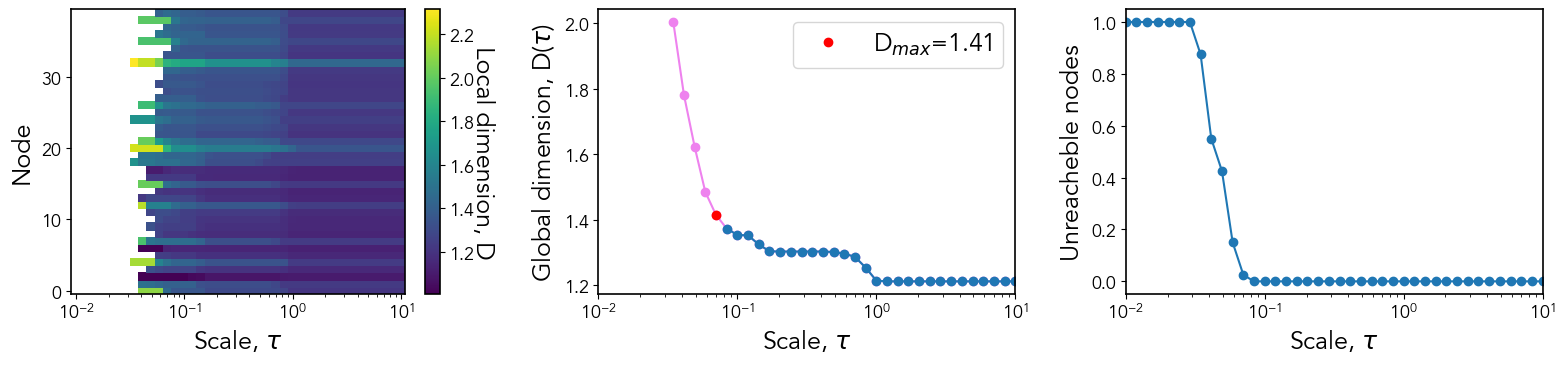

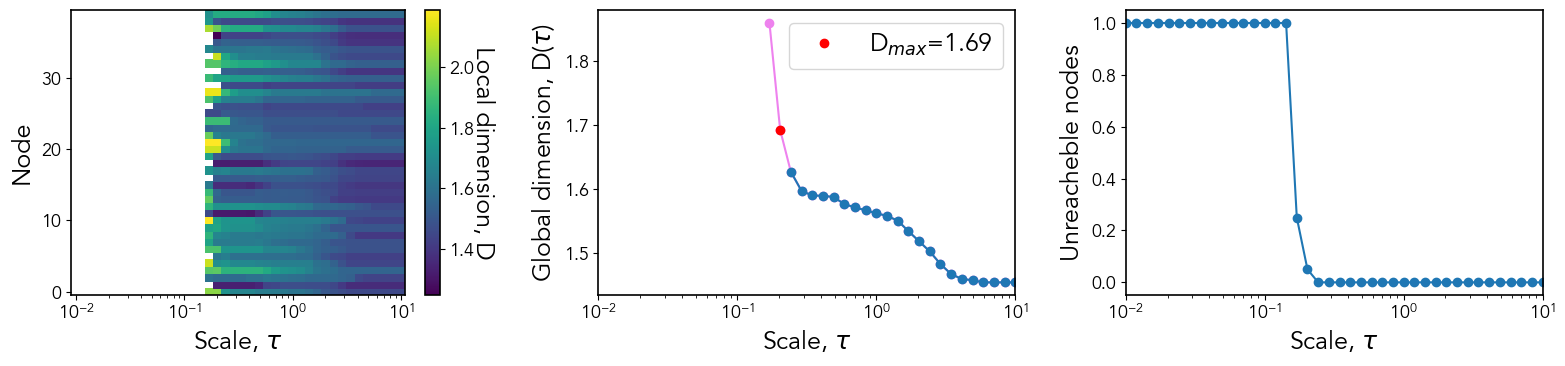

SW


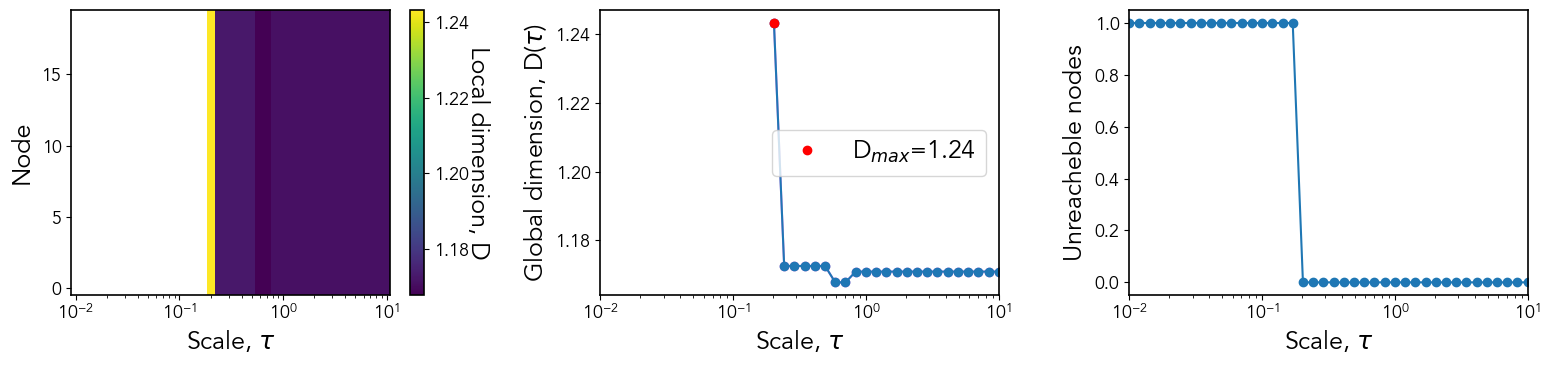

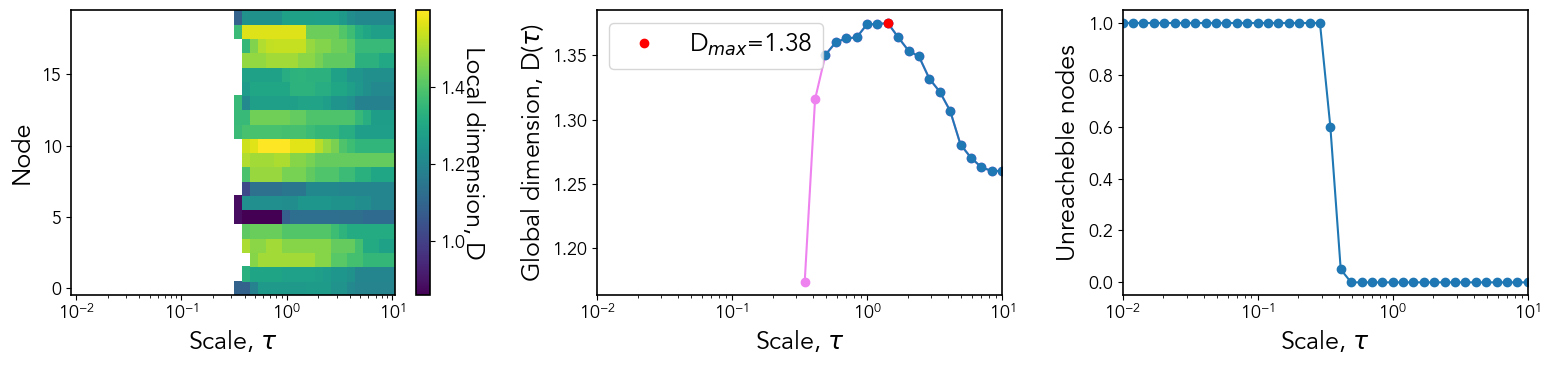

WW


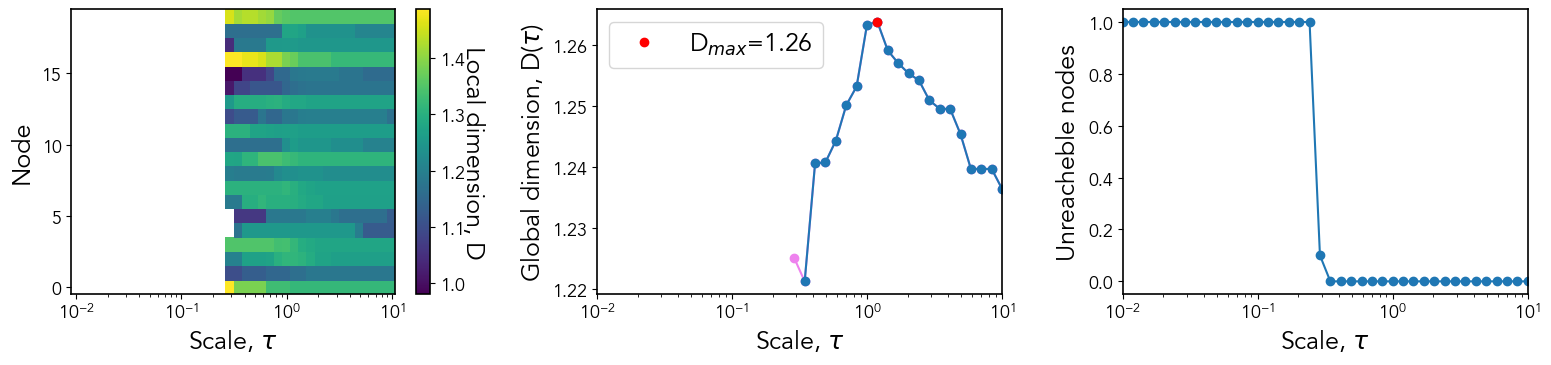

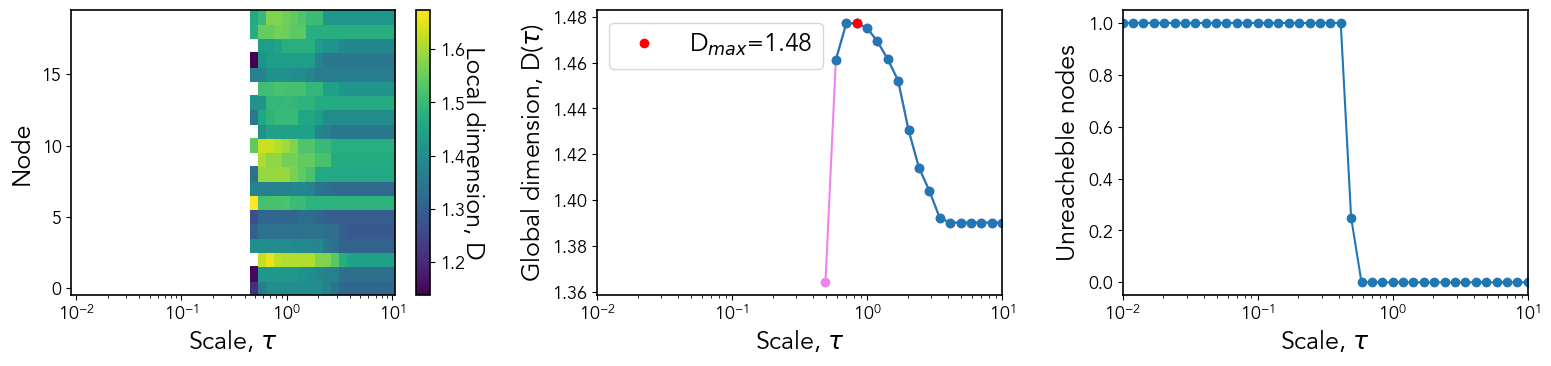

In [49]:
### Generate small networks as examples
N_smalls = [40, 20, 20]

ks = [[7, 7],  [5, 5], [7,7]]
others = [[0.06, 0.2], [0.0, 0.6], [0.65, 3]]

# Create info network for SBM
L = 4
M = N_smalls[0] // L
info_network = {'N': N_smalls[0], 'L': L, 'M': M}

# Times
t_min = -2
t_max = 1
n_t = 40
times = np.logspace(t_min, t_max, n_t)

# Generate networks and compute dims
seed = 0
np.random.seed(seed)
nets_to_show = []
local_dims_to_show = []

for idx_i, typ in enumerate(types):
    print(typ)
    info_network['N'] = N_smalls[idx_i]
    
    for idx_j in range(2):
        k = ks[idx_i][idx_j]
        other = others[idx_i][idx_j]
        
        # Generate network
        mat = None
        while mat is None:
            mat = create_network(typ, k, other, info_network, weighted=False, seed=seed)
        nets_to_show.append(mat)
        
        # Compute dim
        local_dimensions = dyngdim.run_local_dimension(nx.from_numpy_array(mat/mat.max()), times, n_workers=n_t, use_spectral_gap=True)    
        dim, dim_all = plot_results(times, local_dimensions, mat)
        local_dims_to_show.append(dim_all)

In [5]:
'''
# Load network examples
idx_k = [[7, 16],  [0, 0], [7,16]]
idx_others = [[0, 20], [0, 15], [0, 24]]

nets_to_show = []
local_dims_to_show = []

for idx_i, typ in enumerate(types):
    # Get names
    ks, others = [], []
    for file in os.listdir(directory+typ):
        k = float(file.split('_')[4])
        other = float(file.split('_')[-1][:-4])
        ks.append(k), others.append(other)
    ks, others = np.unique(ks), np.unique(others)
    
    for idx_j, idx_other in enumerate(idx_others[idx_i]):
        k = ks[idx_k[idx_i][idx_j]]
        other = others[idx_other]
        
        # Load results
        fname = directory+typ+f'/dim_N_{N}_k_{k}_other_{other}.npy'
        local_dims_to_show.append(np.load(fname))
        
        # Load matrix
        fname = directory+typ+f'/mat_N_{N}_k_{k}_other_{other}.npy'
        nets_to_show.append(np.load(fname))
'''

"\n# Load network examples\nidx_k = [[7, 16],  [0, 0], [7,16]]\nidx_others = [[0, 20], [0, 15], [0, 24]]\n\nnets_to_show = []\nlocal_dims_to_show = []\n\nfor idx_i, typ in enumerate(types):\n    # Get names\n    ks, others = [], []\n    for file in os.listdir(directory+typ):\n        k = float(file.split('_')[4])\n        other = float(file.split('_')[-1][:-4])\n        ks.append(k), others.append(other)\n    ks, others = np.unique(ks), np.unique(others)\n    \n    for idx_j, idx_other in enumerate(idx_others[idx_i]):\n        k = ks[idx_k[idx_i][idx_j]]\n        other = others[idx_other]\n        \n        # Load results\n        fname = directory+typ+f'/dim_N_{N}_k_{k}_other_{other}.npy'\n        local_dims_to_show.append(np.load(fname))\n        \n        # Load matrix\n        fname = directory+typ+f'/mat_N_{N}_k_{k}_other_{other}.npy'\n        nets_to_show.append(np.load(fname))\n"

1.0066634278466573 2.1883426648694586
1.0066634278466573 2.1883426648694586
1.1233369356596408 1.563902643550687
1.1233369356596408 1.563902643550687
1.1607536143629915 1.6199325961759248
1.1607536143629915 1.6199325961759248


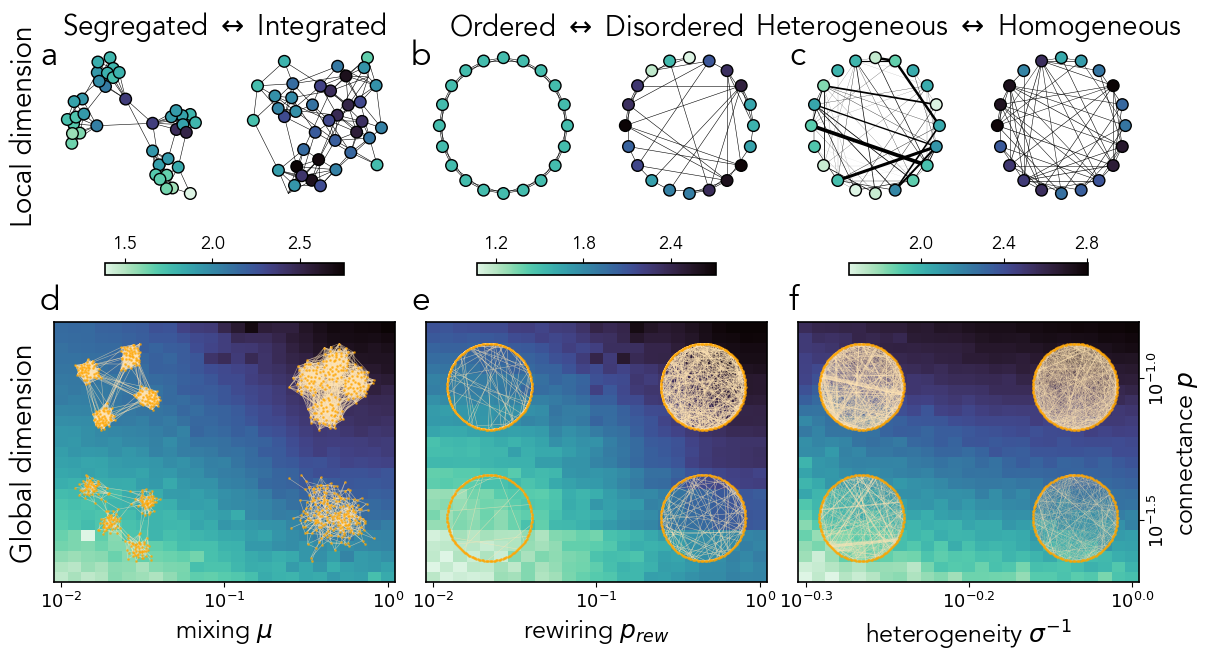

In [50]:
### Global info
figsize=(14,7)
nrows = 2
ncols = 3*2
height_ratios = [1,2.2] #2.35
title_size = 20
ylabel_size = 20
labelpad = 10
letter_size = 24

# Network info
node_color = 'k'
node_size = 70
edge_width = 0.4

node_size_small = 1
edge_width_small = 0.1
node_color_small = 'orange'
edge_color_small = 'moccasin' #'white'#'wheat'
alpha_small = 0.6

x_labels= [r'mixing $\mu$', 'rewiring $p_{rew}$', 'heterogeneity $\sigma^{-1}$']
#titles = ['segregated', 'integrated', 'ordered', 'disordered', 'heterogeneous', 'homogeneous']
titles = [r'Segregated $\leftrightarrow$ Integrated', r'Ordered $\leftrightarrow$ Disordered', r'Heterogeneous $\leftrightarrow$ Homogeneous']

# Graph to plot
width = 0.1
height = 0.1
idxs_graph_to_plot = [[4, 5], [4, -9], [-7, 5], [-7, -9]]
#pos_to_plot = [[0,0], [0, 1], [1,0], [1,1]]
pos_to_plot = [3, 4, 2, 1]

N = 200
L = 4
M = N // L
info_network = {'N': N, 'L': L, 'M': M}

### Generate figure
fig = plt.figure(figsize=figsize) #, layout="constrained")
gs = GridSpec(nrows, ncols, figure=fig, height_ratios=height_ratios)

axs = [fig.add_subplot(gs[0, 2*idx:2*idx+2]) for idx in range(ncols//2)]
[axs[idx].set_title(titles[idx], size=title_size) for idx in range(ncols//2)]
[axs[idx].axis('off') for idx in range(ncols//2)]

### Network examples
axs = [fig.add_subplot(gs[0, idx]) for idx in range(ncols)]
for idx in range(ncols):
    # Plot network
    G = nx.from_numpy_array(nets_to_show[idx])
    vmin, vmax = dim_avg[idx//2]['dim'].values.min(), dim_avg[idx//2]['dim'].values.max()
    
    pos = None
    if types[idx//2]=='SW' or types[idx//2]=='WW':
        pos = nx.circular_layout(G)
    if types[idx//2]=='WW':
        edges = np.array([G[u][v]['weight'] for u,v in G.edges()])**0.9 * edge_width
    else:
        edges = edge_width
    vmin, vmax = np.nanmin(local_dims_to_show[2*(idx//2):2*(idx//2)+2]), np.nanmax(local_dims_to_show[2*(idx//2):2*(idx//2)+2])
    
    nx.draw(G, ax=axs[idx], pos=pos, node_size=node_size, edgecolors='k', cmap=my_cmap,
            node_color=local_dims_to_show[idx], width=edges,
            vmin=vmin, vmax=vmax)
    #nx.draw(G, ax=axs[idx], pos=pos, node_size=node_size, node_color=node_color, width=edge_width)
    
    # Add row title
    if idx==0:
        axs[idx].axis('on') 
        #axs[idx].tick_params(labelleft=True)
        axs[idx].set_ylabel(r'Local dimension', size=ylabel_size, labelpad=labelpad)
    
        # Remove spines and ticks
        axs[idx].set_yticks([])
        axs[idx].set_xticks([])
        axs[idx].spines[['right', 'left', 'top', 'bottom']].set_visible(False)

### Average dimension
axs = [fig.add_subplot(gs[1, 2*idx:2*idx+2]) for idx in range(ncols//2)]
for idx, ress in enumerate(dim_avg):
    ### Load data
    ks = ress['k'].values
    ks = np.unique(ks)
    other = ress['other'].values
    other = np.unique(other)
    dims = ress['dim'].values.reshape(ks.size, other.size)
    
    ### Plot dimension
    im = axs[idx].pcolormesh(np.log10(other), np.log10(ks/N), dims, cmap=my_cmap)
    axs[idx].set_xlabel(x_labels[idx])
    cb = fig.colorbar(im, orientation='horizontal', location='top', pad=0.13, shrink=0.7) ##0.03
    cb.locator = MaxNLocator(nbins=3)
    cb.update_ticks()
    
    ### Plot graphs
    for idx_to_plot, (idx_x, idx_y) in enumerate(idxs_graph_to_plot):
        # Generate matrix
        mat = None
        while mat is None:
            mat = create_network(types[idx], ks[idx_x], other[idx_y], info_network, weighted=False, seed=None)
        G = nx.from_numpy_array(mat)
        if types[idx]=='SBM':
            pos = nx.spring_layout(G)
        else:
            pos = nx.circular_layout(G)
        if types[idx]=='WW':
            edges = np.array([G[u][v]['weight'] for u,v in G.edges()])**0.8
            #edges = edges / edges.max() * edge_width_small
            edges = edges * edge_width_small
        else:
            edges = edge_width
        
        # Define position
        left, bottom, width, height = np.log10(ks[idx_x]), np.log10(other[idx_y]), width, height
        #ax2 = axs[idx].inset_axes([left, bottom, width, height], transform=axs[idx].transData)
        ax2 = inset_axes(axs[idx], width="30%", height="40%", loc=pos_to_plot[idx_to_plot])
        
        # Draw
        nx.draw(G, ax=ax2, node_size=node_size_small, node_color=node_color_small, width=edges, pos=pos, alpha=alpha_small, edge_color=edge_color_small)
    
    # Set xticks
    if idx<ncols//2-1:
        axs[idx].set_xticks([-2, -1, 0])
        axs[idx].xaxis.set_major_formatter(FormatStrFormatter(r'$10^{%.d}$'))
    else:
        axs[idx].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axs[idx].xaxis.set_major_formatter(FormatStrFormatter(r'$10^{%.1f}$'))
    
    if idx==0:
        # Add row title
        axs[idx].set_ylabel('Global dimension', size=ylabel_size, labelpad=labelpad)
        axs[idx].set_yticks([])
    elif idx==ncols//2-1:
        # Put ylabel on the right
        axs[idx].yaxis.set_label_position("right")
        axs[idx].yaxis.tick_right()
        axs[idx].tick_params(axis='y', rotation=90)
        axs[idx].set_yticks([-1.5, -1])
        axs[idx].yaxis.set_major_formatter(FormatStrFormatter(r'$10^{%.1f}$'))
        axs[idx].set_ylabel(r'connectance $p$')
        # Adjust alignment for rotated tick labels
        for label in axs[idx].get_yticklabels(): label.set_va('center')  # Center-align vertically
    else:
        axs[idx].set_yticks([])
        
### Add letters
ax = plt.gca()
h0, h1 = 0.85, 0.5
l0, l1, l2 = 0.115, 0.38, 0.65
fig.text(l0,h0, 'a', size=letter_size)
fig.text(l1,h0, 'b', size=letter_size)
fig.text(l2,h0, 'c', size=letter_size)
fig.text(l0,h1, 'd', size=letter_size)
fig.text(l1,h1, 'e', size=letter_size)
fig.text(l2,h1, 'f', size=letter_size)

plt.subplots_adjust(hspace=0.05)
#plt.savefig(folder_figures+'fig2.png', dpi=400, bbox_inches='tight', pad_inches=0.23)
plt.savefig(folder_figures+'fig2.svg', bbox_inches='tight', pad_inches=0.23)
plt.show()

# Connectome - local dimension

In [3]:
### GLOBAL VARIABLES
cs = sns.color_palette("deep")

parc = 200
session = 1

directory = folder_results+'dimensionality/'

In [4]:
### LOAD RESULTS
which = 'dimensionality'
ress_dim = load_result(which, var_name='dim', thr='mask', include_subctx=False)

which = 'criticality'
ress_crit = load_result(which, var_name='crit', thr='mask', include_subctx=False)

ress = pd.merge(ress_dim, ress_crit, how='left', left_on=ress_dim.columns[:-2].tolist(), right_on=ress_crit.columns[:-2].tolist())

### GET SPECIFIC PARCELLATION
ress = ress.loc[ress['parc'] == parc].drop(columns='parc')

### LOAD BEHAVIORAL RESULTS
behavior = pd.read_excel('/data/barzon/arm2/factor_cognition.xlsx', index_col=0)

# Change column name entries to uniform with ress
behavior['study_id'] = [tmp.replace('FCS_', 'sub-') for tmp in behavior['study_id']]
behavior = behavior.rename(columns={'study_id': 'sub'})

# Create group & session columns column
tmp_session = [2 if ('3months' in tmp) else 1 for tmp in behavior['Diax']]
tmp_group = ['control' if ('control' in tmp) else 'stroke' for tmp in behavior['Diax']]

behavior.insert(0, "name", tmp_group, True)
behavior.insert(1, "session", tmp_session, True)

# Remove column Diax
behavior = behavior.drop(['Diax'], axis='columns')

# Merge
ress = pd.merge(ress, behavior, how="left", left_on=ress.columns[:3].tolist(), right_on=behavior.columns[:3].tolist())

# Store factor names
names_factor = ress.columns[-5:].values.astype(str)

######## control - ses 01 - parc 100 - total 29 - thr mask - subctx False ########
######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
######## control - ses 01 - parc 500 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 100 - total 51 - thr mask - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr mask - subctx False ########
######## stroke - ses 01 - parc 500 - total 51 - thr mask - subctx False ########
######## control - ses 01 - parc 100 - total 29 - thr mask - subctx False ########
######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
######## control - ses 01 - parc 500 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 100 - total 51 - thr mask - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr mask - subctx False ########
######## stroke - ses 01 - parc 500 - total 51 - thr mask - subctx False ########


In [5]:
### Get controls
control = data_loader(which='control', ses=session, parc=parc, include_subctx=False, thr='mask')
stroke = data_loader(which='stroke', ses=session, parc=parc, include_subctx=False, thr='mask')

dim_control_names = ress.loc[ress['name']=='control']['sub'].values
dim_stroke_names = ress.loc[ress['name']=='stroke']['sub'].values

dim_control = ress.loc[ress['name'] == 'control']['dim_avg'].values
dim_stroke = ress.loc[ress['name'] == 'stroke']['dim_avg'].values

dim_controls_local = ress.loc[ress['name']=='control']['dim_all'].values
dim_controls_local = np.stack(dim_controls_local)

dim_stroke_local = ress.loc[ress['name']=='stroke']['dim_all'].values
dim_stroke_local = np.stack(dim_stroke_local)

######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr mask - subctx False ########


In [6]:
### Compute avg local dimension for controls
dim_local_avg = dim_controls_local.mean(axis=0)
#np.save(directory+f'dim_local_avg_N_{parc}.npy', dim_local_avg)

In [15]:
### Load myelin
from neuromaps.datasets import fetch_annotation, available_annotations
from netneurotools import datasets as nntdata
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
from neuromaps.transforms import fslr_to_fslr
from enigmatoolbox.permutation_testing import spin_test, shuf_test

### Download parcellation
schaefer = nntdata.fetch_schaefer2018('fslr32k')[f'{parc}Parcels7Networks']

### Create parcellator
parcellator = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')

### Download map
myelinmap = fetch_annotation(source='hcps1200', desc='myelinmap')

### Parcellate
myelin_parc = parcellator.fit_transform(myelinmap, 'fsLR')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [16]:
### Compute avg by RSN

# Get ROIs
rois = control.get_rois()
coords = rois[['R','A','S']].values

roi_rsn = rois['ROI Name'].values
roi_rsn = np.array( [tmp.split('_')[2] for tmp in roi_rsn] )
rsn_names = np.unique(roi_rsn).astype(str)
print(rsn_names)

rsn_idx = [np.where(roi_rsn==tmp)[0] for tmp in rsn_names]

#avg_dim = np.array( [dim_local_avg[tmp_idx].mean() for tmp_idx in rsn_idx] )
avg_dim = [dim_controls_local[:,tmp_idx].mean(axis=1) for tmp_idx in rsn_idx]
avg_dim = np.stack( avg_dim )

new_rsn_names = np.array( ['Fp', 'Dmn', 'Da', 'Lim', 'Va', 'Sm', 'Vis'] )
print(new_rsn_names)

avg_dim_rsn = pd.DataFrame(avg_dim.T, columns=new_rsn_names)

idx_to_plot = np.argsort(avg_dim.mean(axis=1))#[::-1]
avg_dim_rsn = avg_dim_rsn[new_rsn_names[idx_to_plot]]

['Cont' 'Default' 'DorsAttn' 'Limbic' 'SalVentAttn' 'SomMot' 'Vis']
['Fp' 'Dmn' 'Da' 'Lim' 'Va' 'Sm' 'Vis']


/home/barzon/.local/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/barzon/.local/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


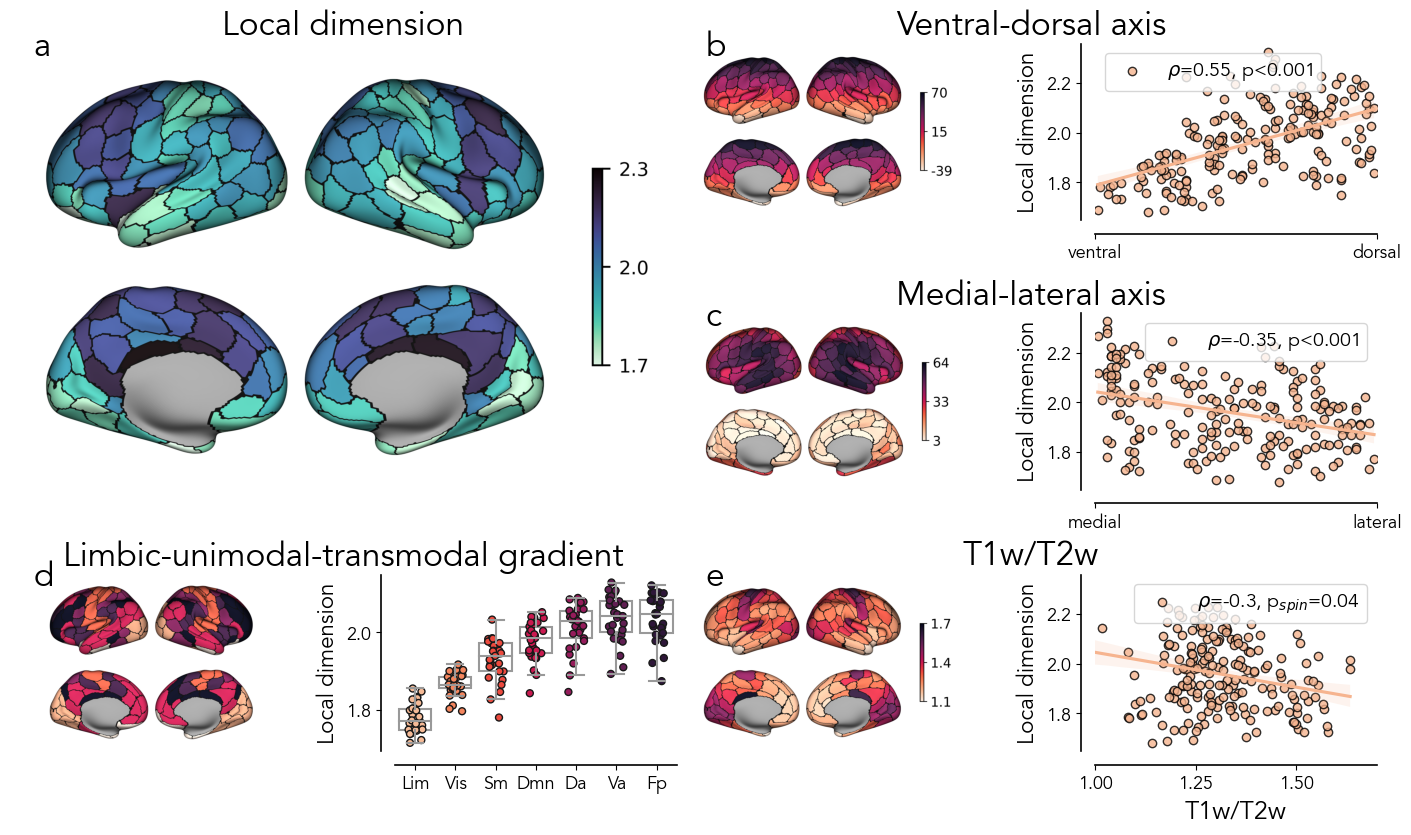

In [9]:
### Global info
figsize=(14,10)
nrows = 4
ncols = 4
height_ratios = [1,1,1,1]
width_ratios = [1,1,1,1]
title_size = 24
ylabel_size = 16
offset = 10
letter_size = 24
legend_size = 14
my_color = sns.color_palette('rocket_r')[0] #my_cmap(0.6)

### Generate figure
fig = plt.figure(figsize=figsize, layout='constrained')
gs = GridSpec(nrows, ncols, figure=fig, height_ratios=height_ratios, width_ratios=width_ratios)

### Map of average local dimension
# Load image
img = np.asarray(Image.open(folder_figures+f'fig_dim_local_avg_N_{parc}.png'))
ax = fig.add_subplot(gs[0:2, 0:2])
ax.imshow(img)
plt.axis('off')

### Correlation w axis
data_x = [coords[:,2], np.abs(coords[:,0])]
names = ['z', '|x|']
tick_labels = [['ventral', 'dorsal'], ['medial', 'lateral']]

for idx in range(2):
    # brain map
    if idx == 1:
        fname = folder_figures+f'fig_medial_lateral_N_{parc}.png'
    else:
        fname = folder_figures+f'fig_ventral_dorsal_N_{parc}.png'
    img = np.asarray(Image.open(fname))
    ax = fig.add_subplot(gs[idx, 2])
    ax.imshow(img)
    plt.axis('off')  
        
    # scatter plot
    ax = fig.add_subplot(gs[idx,3])
    x = data_x[idx]
    y = dim_controls_local.mean(axis=0)
    rho, pval = pearsonr(x, y)
    if pval<1e-3:
        label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
    else:
        label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
    sns.regplot(x=x, y=y, ax=ax, label=label, color=my_color, scatter_kws={'edgecolor':'k', 'linewidth':1})
    sns.despine(offset=offset, bottom=False, ax=ax)
    ax.legend(prop={'size':legend_size})
    #ax.set_xlabel(names[idx])
    ax.set_ylabel('Local dimension', size=ylabel_size)
    delta = x.max()-x.min()
    xlims = (x.min()-delta*0.01, x.max()+delta*0.01)
    ax.set_xlim(xlims)
    ax.set_xticks(xlims, tick_labels[idx])

### Relation w RSN
# Load image
img = np.asarray(Image.open(folder_figures+f'fig_rsn_N_{parc}.png'))
ax = fig.add_subplot(gs[2, 0])
ax.imshow(img)
plt.axis('off')

ax = fig.add_subplot(gs[2, 1])
sns.boxplot(data=avg_dim_rsn, fliersize=0, color='white', ax=ax, zorder=2)
sns.stripplot(data=avg_dim_rsn, dodge=True, alpha=1.0, jitter=0.2, edgecolor='gray', linewidth=1, palette="rocket_r", ax=ax, zorder=1)
sns.despine(offset=offset, bottom=False, ax=ax)
ax.set_ylabel('Local dimension', size=ylabel_size)
ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

### Correlation w myelin
# Load image
img = np.asarray(Image.open(folder_figures+f'fig_myelin_N_{parc}.png'))
ax = fig.add_subplot(gs[2,2])
ax.imshow(img)
plt.axis('off')

# Plot correlation
ax = fig.add_subplot(gs[2,3])
x = myelin_parc
y = dim_controls_local.mean(axis=0)
rho, pval = pearsonr(x, y)
label = r'$\rho$=' + str(round(rho, 2))+ r', p$_{spin}$=0.04'
sns.regplot(x=x, y=y, ax=ax, label=label, color=my_color, scatter_kws={'edgecolor':'k', 'linewidth':1})
sns.despine(offset=offset, bottom=False, ax=ax)
ax.set_xlabel('T1w/T2w')
ax.set_ylabel('Local dimension', size=ylabel_size)
ax.set_xlim(1,1.7)
ax.legend(prop={'size':legend_size})
ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
ax.xaxis.set_major_locator(MaxNLocator(nbins=3))

### Add titles
#titles = ['Average local dimension', 'Ventral-dorsal axis', 'Medial-lateral axis', 'Transmodal-unimodal gradient', '', '']
#[ax.set_title(titles[idx], size=title_size) for idx, ax in enumerate(fig.axes)]
fig.axes[0].set_title('Local dimension', size=title_size)

ax = fig.add_subplot(gs[2,:2])
ax.set_title('Limbic-unimodal-transmodal gradient', size=title_size)
plt.axis('off')

# Add fake axs to myelin, gradient and rsn
titles = ['Ventral-dorsal axis', 'Medial-lateral axis', 'T1w/T2w']
for idx, title in enumerate(titles):
    ax = fig.add_subplot(gs[idx,2:])
    ax.set_title(title, size=title_size)
    plt.axis('off')

### Add letters
ax = plt.gca()
h0, h1, h2 = 0.95, 0.68, 0.42
l0, l1 = 0.02, 0.5
#h0, h1, h2 = 0.88, 0.62, 0.28
#l0, l1 = 0.15, 0.62
fig.text(l0,h0, 'a', size=letter_size)
fig.text(l1,h0, 'b', size=letter_size)
fig.text(l1,h1, 'c', size=letter_size)
fig.text(l0,h2, 'd', size=letter_size)
fig.text(l1,h2, 'e', size=letter_size)

#plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.savefig(folder_figures+'fig3.png', dpi=200, bbox_inches='tight')
plt.show()

# Stroke

In [7]:
color_control = my_cmap(0.6)
color_stroke = 'orange'#my_cmap(0.25)
cs = (color_control, color_stroke)

In [8]:
### GET SPECIFIC SESSION
ress = ress.loc[ress['session'] == session].drop(columns='session')

In [9]:
### Get controls
control = data_loader(which='control', ses=session, parc=parc, include_subctx=False, thr='mask')
stroke = data_loader(which='stroke', ses=session, parc=parc, include_subctx=False, thr='mask')

dim_control_names = ress.loc[ress['name']=='control']['sub'].values
dim_stroke_names = ress.loc[ress['name']=='stroke']['sub'].values

dim_control = ress.loc[ress['name'] == 'control']['dim_avg'].values
dim_stroke = ress.loc[ress['name'] == 'stroke']['dim_avg'].values

dim_controls_local = ress.loc[ress['name']=='control']['dim_all'].values
dim_controls_local = np.stack(dim_controls_local)

dim_stroke_local = ress.loc[ress['name']=='stroke']['dim_all'].values
dim_stroke_local = np.stack(dim_stroke_local)

######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr mask - subctx False ########


In [10]:
### Load lesion size
fname = '/data/barzon/arm2/Demographic.xlsx'
dfs = pd.read_excel(fname)

### Keep only stroke
is_stroke = [float(tmp.split('-')[1])>=200 for tmp in dfs['ID'].values]
dfs_names = dfs['ID'].values[is_stroke]
# Get lesion volume
dfs_volume = dfs['lesion_volume'].values[is_stroke]

# Get subset dfs
subset_dfs = dfs.iloc[is_stroke]
subset_dfs = subset_dfs[['ID', 'lesion_volume']]

# Create merged dataset
subset_dim_stroke = pd.DataFrame(np.array([dim_stroke_names, dim_stroke]).T, columns=['ID', 'dim'])
# Merge lesion volume
subset_merged = pd.merge(subset_dfs, subset_dim_stroke, left_on='ID', right_on='ID')
subset_merged['dim'] = subset_merged['dim'].astype(float)

In [28]:
### Compute structural features
control = data_loader(which='control', ses=session, parc=parc, include_subctx=False, thr='mask')
stroke = data_loader(which='stroke', ses=session, parc=parc, include_subctx=False, thr='mask')

dim_control = ress.loc[ress['name'] == 'control']['dim_avg'].values
dim_stroke = ress.loc[ress['name'] == 'stroke']['dim_avg'].values

ress_control = []
ress_stroke = []

normalize = False

### Compute
print('Controls')
for idx, mat in enumerate(control):
    if mat is None:
        continue
        
    if normalize:
        mat /= mat.max()
    
    G = nx.from_numpy_array(mat)
    
    ### avg degree
    deg = mat.sum(axis=1).mean()
    
    ### char path length
    clust = nx.average_clustering(G, weight='weight')
    
    ### modularity
    comms = nx.community.louvain_communities(G, weight='weight')
    mod = nx.community.modularity(G, comms)
    
    ress_control.append([deg, clust, mod])
    
### Compute
print('Stroke')
for idx, mat in enumerate(stroke):
    if mat is None:
        continue
        
    if normalize:
        mat /= mat.max()
        #mat = mat / mat.sum(axis=1)[:,None]
    
    G = nx.from_numpy_array(mat)
    
    ### avg degree
    deg = mat.sum(axis=0).mean()
    print(deg)
    
    ### char path length
    clust = nx.average_clustering(G, weight='weight')
    
    ### modularity
    comms = nx.community.louvain_communities(G, weight='weight')
    mod = nx.community.modularity(G, comms)
    
    ress_stroke.append([deg, clust, mod])

## Stack
ress_control = np.stack(ress_control)
ress_stroke = np.stack(ress_stroke)

## Normalize degree
ress_control[:,0] = ress_control[:,0] / 1e4
ress_stroke[:,0] = ress_stroke[:,0] / 1e4

######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr mask - subctx False ########
Controls
- Loading sub-040
- Loading sub-041
- Loading sub-042
- Loading sub-043
- Loading sub-044
- Loading sub-045
- Loading sub-046
- Loading sub-047
- Loading sub-048
- Loading sub-049
- Loading sub-050
- Loading sub-051
- Loading sub-052
- Loading sub-055
- Loading sub-057
- Loading sub-059
- Loading sub-060
- Loading sub-061
- Loading sub-062
- Loading sub-063
- Loading sub-064
- Loading sub-065
- Loading sub-066
- Loading sub-067
- Loading sub-068
- Loading sub-069
- Loading sub-070
- Loading sub-071
- Loading sub-072
Stroke
- Loading sub-200
27419.013577820002
- Loading sub-201
30791.466604359997
- Loading sub-202
31498.541302929996
- Loading sub-203
28784.89611482
- Loading sub-204
30945.3214025
- Loading sub-205
27954.63068957
- Loading sub-206
23189.762783719998
- Loading sub-208
27902.26288099
- Loading sub-209


Correlazione lesion center - Linear mixed model
$D_{i,s} = R_s + R_i + \alpha * l_{i,c}$

In [11]:
### Load lesion center
fname = '/data/barzon/arm2/lesion_center.xlsx'
lesion_center = pd.read_excel(fname)
lesion_center = lesion_center.rename(columns={'ID':'sub'})

### Load ROI location in MNI space
new_pos = control.get_rois_mni().values[:,1:4]

### Extract local dimensionality
linear = ress.loc[ress['name']=='stroke']
linear = linear[['sub','dim_all']]

### Add lesion center
linear = pd.merge(linear, lesion_center, left_on='sub', right_on='sub')

### Expand local dimension
linear = linear.explode('dim_all')
n_subj = len(np.unique(linear['sub'].values))

### Add avg dimension for healthy
linear['dim_health'] = np.tile(dim_local_avg, n_subj)

### Add ROI location
linear[['x', 'y', 'z']] = np.tile(new_pos.T, n_subj).T

### Add node index
linear['node'] = np.tile(np.arange(parc), n_subj)

### Change dtype
linear = linear.astype({'dim_all': 'float64', 'x': 'float64', 'y': 'float64', 'z': 'float64'})

### Compute distance from each ROI to lesion location
lesion_center = linear[['x_lesion', 'y_lesion', 'z_lesion']].values
coords_long = linear[['x', 'y', 'z']].values
diff = lesion_center-coords_long
diff = diff**2
diff = np.sqrt( diff.sum(axis=1) )
linear['distance'] = diff

### Compute delta dimension
dim_local_long = linear['dim_all'].values
dim_healthy_long = linear['dim_health'].values
linear['delta_dim'] = (dim_local_long - dim_healthy_long)

### Change column type
linear['delta_dim'] = linear['delta_dim'].astype(float)
linear['dim_all'] = linear['dim_all'].astype(float)
linear['sub'] = linear['sub'].astype(str)
linear['node'] = linear['node'].astype(str)

### Drop columns
linear = linear.drop(columns=['x_lesion', 'y_lesion', 'z_lesion', 'x', 'y', 'z', 'dim_all', 'dim_health'])

### Drop nans
#linear = linear.dropna()

# Get subjects with nans
subj_to_remove = linear.loc[linear.isnull().any(axis=1)].index
subj_to_remove = np.unique(subj_to_remove)
linear = linear.drop(subj_to_remove)

linear.to_csv(folder_results+'distance_delta_dim.csv')

In [12]:
linear_rescaled = linear.copy()

linear_rescaled['delta_dim'] = linear_rescaled['delta_dim'] - linear_rescaled['delta_dim'].mean()
linear_rescaled['delta_dim'] = linear_rescaled['delta_dim'] / np.std(linear_rescaled['delta_dim'])

linear_rescaled['distance'] = linear_rescaled['distance'] - linear_rescaled['distance'].mean()
linear_rescaled['distance'] = linear_rescaled['distance'] / np.std(linear_rescaled['distance'])

In [13]:
ttest_ind(dim_control, dim_stroke)

Ttest_indResult(statistic=4.012901273506598, pvalue=0.00013797842124534216)

In [14]:
### Compute ROI closest to lesion center
# Load lesion center
fname = '/data/barzon/arm2/lesion_center.xlsx'
lesion_center = pd.read_excel(fname)
lesion_center = lesion_center.rename(columns={'ID':'sub'})

# Load ROI location in MNI space
new_pos = control.get_rois_mni().values[:,1:4]

# Extract local dimensionality
linear = ress.loc[ress['name']=='stroke']
linear = linear[['sub','dim_all']]

# Add lesion center
linear = pd.merge(linear, lesion_center, left_on='sub', right_on='sub')

# Expand local dimension
linear = linear.explode('dim_all')
n_subj = len(np.unique(linear['sub'].values))

# Add avg dimension for healthy
linear['dim_health'] = np.tile(dim_local_avg, n_subj)

# Add ROI location
linear[['x', 'y', 'z']] = np.tile(new_pos.T, n_subj).T

# Add node index
linear['node'] = np.tile(np.arange(parc), n_subj)

# Change dtype
linear = linear.astype({'dim_all': 'float64', 'x': 'float64', 'y': 'float64', 'z': 'float64'})

# Compute distance from each ROI to lesion location
lesion_center = linear[['x_lesion', 'y_lesion', 'z_lesion']].values
coords_long = linear[['x', 'y', 'z']].values
diff = lesion_center-coords_long
diff = diff**2
diff = np.sqrt( diff.sum(axis=1) )
linear['distance'] = diff

# Compute delta dimension
dim_local_long = linear['dim_all'].values
dim_healthy_long = linear['dim_health'].values
linear['delta_dim'] = (dim_local_long - dim_healthy_long)

# Change column type
linear['delta_dim'] = linear['delta_dim'].astype(float)
linear['dim_all'] = linear['dim_all'].astype(float)
linear['sub'] = linear['sub'].astype(str)
linear['node'] = linear['node'].astype(str)

# Compute ROI closest to lesion center
roi_center = [np.argmin( linear.iloc[idx_subj*parc:(idx_subj+1)*parc]['distance'] ) for idx_subj in range(n_subj)]
roi_center = np.array(roi_center)

### Compute graph distance from lesion center
graph_distance_from_lesion_center = np.zeros((n_subj, parc))

normalize = True

for idx, name in enumerate(np.unique(linear['sub'])):
    # Get id matrix in original
    idx_mat = np.where(stroke.names==name)[0]
    
    # Get matrix
    mat = stroke.load_matrix(int(idx_mat))
    
    if mat is None:
        continue
        
    if normalize:
        #mat /= mat.max()
        mat = mat / mat.sum(axis=1)[:,None]
    
    # Get network
    G = nx.from_numpy_array(mat)
    
    # Get id ROI as lesion center
    tmp_center = roi_center[idx]
    
    # Compute shortest distance to ROI lesion center
    spd = nx.algorithms.single_source_dijkstra_path_length(G, tmp_center, weight='weight')
    
    # Reorder
    spd = np.array( list( spd.values() ) )[np.argsort( list( spd.keys() ) )]
    
    # Store results
    graph_distance_from_lesion_center[idx] = spd
    
# Add to dataframe
linear['graph_distance'] = graph_distance_from_lesion_center.flatten()

# Store
subj_to_remove = linear.loc[linear.isnull().any(axis=1)].index
subj_to_remove = np.unique(subj_to_remove)
linear = linear.drop(subj_to_remove)

linear.to_csv(folder_results+'graph_distance_delta_dim.csv')

- Loading sub-200
- Loading sub-201
- Loading sub-202
- Loading sub-203
- Loading sub-204
- Loading sub-205
- Loading sub-206
- Loading sub-208
- Loading sub-209
- Loading sub-210
- Loading sub-213
- Loading sub-216
- Loading sub-219
- Loading sub-222
- Loading sub-224
- Loading sub-226
- Loading sub-232
- Loading sub-233
- Loading sub-234
- Loading sub-235
- Loading sub-238
- Loading sub-239
- Loading sub-240
- Loading sub-243
- Loading sub-245
- Loading sub-246
- Loading sub-247
- Loading sub-249
- Loading sub-250
- Loading sub-251
- Loading sub-252
- Loading sub-253
- Loading sub-256
- Loading sub-260
- Loading sub-261
- Loading sub-262
- Loading sub-263
- Loading sub-264
- Loading sub-265
- Loading sub-266
- Loading sub-267
- Loading sub-268
- Loading sub-269
- Loading sub-272
- Loading sub-273
- Loading sub-274
- Loading sub-275
- Loading sub-277
- Loading sub-279


In [15]:
### Compute connected vs disconnected regions
control = data_loader(which='control', ses=session, parc=parc, include_subctx=False, thr='mask')
stroke = data_loader(which='stroke', ses=session, parc=parc, include_subctx=False, thr='mask')

dim_control = ress.loc[ress['name'] == 'control']['dim_avg'].values
dim_stroke = ress.loc[ress['name'] == 'stroke']['dim_avg'].values

ress_control = []
ress_stroke = []

normalize = False

### Compute
print('Controls')
for idx, mat in enumerate(control):
    if mat is None:
        continue
        
    if normalize:
        mat /= mat.max()
        
    ### avg degree
    deg = mat.sum(axis=1)#.mean()
    
    ress_control.append([deg])
    
### Compute
print('Stroke')
for idx, mat in enumerate(stroke):
    if mat is None:
        continue
        
    if normalize:
        mat /= mat.max()
        #mat = mat / mat.sum(axis=1)[:,None]
        
    ### avg degree
    deg = mat.sum(axis=0)#.mean()
    
    ress_stroke.append([deg])

## Stack
ress_control = np.stack(ress_control)
ress_stroke = np.stack(ress_stroke)

ress_control = np.squeeze(ress_control)
ress_stroke = np.squeeze(ress_stroke)

## Normalize degree
#ress_control[:,0] = ress_control[:,0] / 1e4
#ress_stroke[:,0] = ress_stroke[:,0] / 1e4

######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr mask - subctx False ########
Controls
- Loading sub-040
- Loading sub-041
- Loading sub-042
- Loading sub-043
- Loading sub-044
- Loading sub-045
- Loading sub-046
- Loading sub-047
- Loading sub-048
- Loading sub-049
- Loading sub-050
- Loading sub-051
- Loading sub-052
- Loading sub-055
- Loading sub-057
- Loading sub-059
- Loading sub-060
- Loading sub-061
- Loading sub-062
- Loading sub-063
- Loading sub-064
- Loading sub-065
- Loading sub-066
- Loading sub-067
- Loading sub-068
- Loading sub-069
- Loading sub-070
- Loading sub-071
- Loading sub-072
Stroke
- Loading sub-200
- Loading sub-201
- Loading sub-202
- Loading sub-203
- Loading sub-204
- Loading sub-205
- Loading sub-206
- Loading sub-208
- Loading sub-209
- Loading sub-210
- Loading sub-213
- Loading sub-216
- Loading sub-219
- Loading sub-222
- Loading sub-224
- Loading sub-226
- Loading

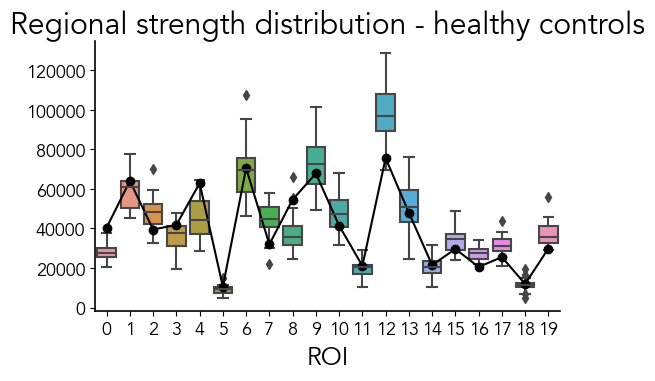

In [8]:
sns.boxplot(data = ress_control[:,:20])
plt.plot(ress_stroke[0,:20], '-o', c='k')
plt.xlabel('ROI')
plt.title('Regional strength distribution - healthy controls')
plt.show()

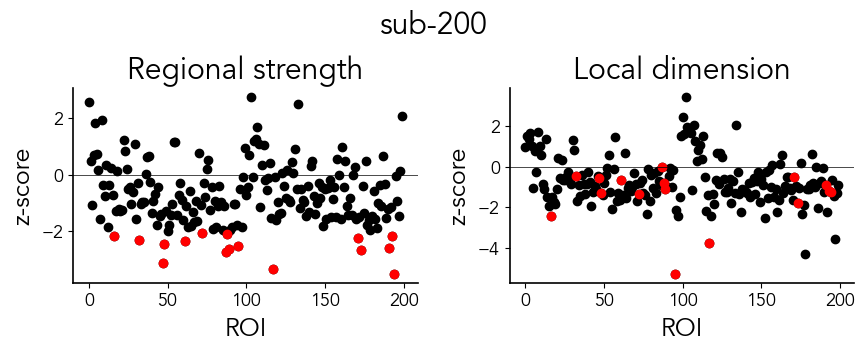

Ttest_indResult(statistic=-2.8375809628607658, pvalue=0.008073649400109472)


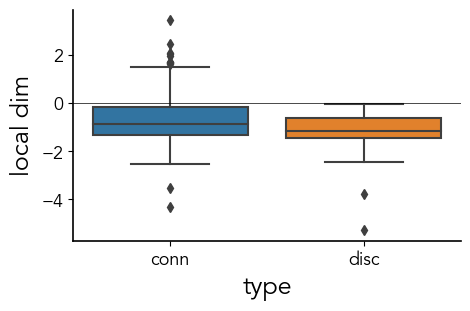

In [9]:
idx_sub = 0

z_score_conn = ( ress_stroke[idx_sub] - ress_control.mean(axis=0) ) / ress_control.std(axis=0)
z_score_dim = ( dim_stroke_local[idx_sub] - dim_controls_local.mean(axis=0) ) / dim_controls_local.std(axis=0)

idx_disconnected = np.where(z_score_conn < -2.)[0]

connection_type = np.array(['conn'] * parc)
connection_type[idx_disconnected] = 'disc'

### Plot z-score for local strength and local dimension
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(np.arange(parc), z_score_conn, 'o', color='k')
plt.plot(np.arange(parc)[idx_disconnected], z_score_conn[idx_disconnected], 'o', c='r')
plt.axhline(0, lw=0.5, c='k')
plt.xlabel('ROI')
plt.ylabel('z-score')
plt.title('Regional strength')

plt.subplot(1,2,2)
plt.plot(np.arange(parc), z_score_dim, 'o', color='k')
plt.plot(np.arange(parc)[idx_disconnected], z_score_dim[idx_disconnected], 'o', c='r')
plt.axhline(0, lw=0.5, c='k')
plt.xlabel('ROI')
plt.ylabel('z-score')
plt.title('Local dimension')

plt.suptitle(f'{dim_stroke_names[idx_sub]}', y=0.9)

plt.tight_layout()
plt.show()

### Plot average local dimension for connected vs disconnected
df = pd.DataFrame(z_score_dim.reshape(-1,1), columns=['local dim'])
df['type'] = connection_type

plt.figure(figsize=(5,3))

sns.boxplot(data=df, x='type', y='local dim')
plt.axhline(0, lw=0.5, c='k')

print(ttest_ind(z_score_dim[idx_disconnected], z_score_dim[~idx_disconnected]))

plt.show()

In [16]:
n_stroke = ress_stroke.shape[0]

avg_conn = np.zeros(n_stroke)
avg_disc = np.zeros(n_stroke)

for idx_sub in range(n_stroke):
    z_score_conn = ( ress_stroke[idx_sub] - ress_control.mean(axis=0) ) / ress_control.std(axis=0)
    z_score_dim = ( dim_stroke_local[idx_sub] - dim_controls_local.mean(axis=0) ) / dim_controls_local.std(axis=0)

    idx_disconnected = np.where(z_score_conn < -2)[0]

    avg_conn[idx_sub] = z_score_dim[~idx_disconnected].mean()
    avg_disc[idx_sub] = z_score_dim[idx_disconnected].mean()
    
df_disc = pd.DataFrame(np.concatenate([avg_conn, avg_disc]), columns=['z_score'])
df_disc['type'] = np.concatenate([ ['conn'] * n_stroke, ['disc'] * n_stroke])

/tmp/ipykernel_39330/2071327221.py:12: RuntimeWarning: Mean of empty slice.
  avg_conn[idx_sub] = z_score_dim[~idx_disconnected].mean()
/home/barzon/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_39330/2071327221.py:13: RuntimeWarning: Mean of empty slice.
  avg_disc[idx_sub] = z_score_dim[idx_disconnected].mean()


Ttest_indResult(statistic=-12.129583662921748, pvalue=0.00672833807187483)


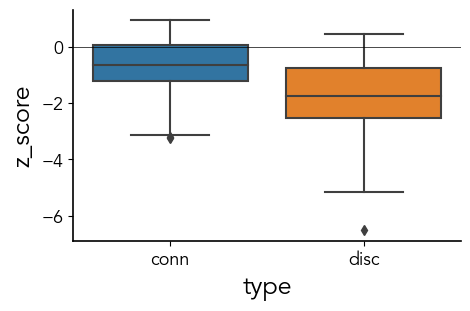

In [17]:
plt.figure(figsize=(5,3))

sns.boxplot(data=df_disc, x='type', y='z_score')
plt.axhline(0, lw=0.5, c='k')

print(ttest_ind(z_score_dim[idx_disconnected], z_score_dim[~idx_disconnected]))

plt.show()

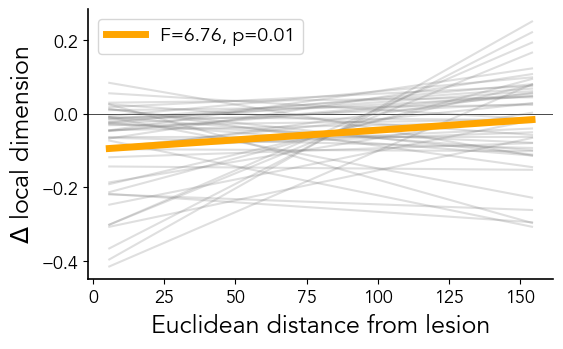

In [18]:
ax = plt.subplot(1, 1, 1)

xmin, xmax = linear['distance'].values.min(), linear['distance'].values.max()
ymin, ymax = linear['delta_dim'].values.min(), linear['delta_dim'].values.max()
xrange = np.linspace(xmin, xmax, 100, endpoint=True)
yrange = np.linspace(ymin, ymax, 100, endpoint=True)

b_group = 0.01504
m_group = 0.1106

for subj in np.unique(linear['sub'].values):
    #extract data
    val_to_fit = linear.loc[linear['sub']==subj]
    x, y = val_to_fit['distance'].values, val_to_fit['delta_dim'].values
    
    # linear fit
    m,b = np.polyfit(x, y, 1)
    
    # plot
    plt.plot(xrange, m*xrange+b, c='gray', alpha=0.25)
    
y_tilde = np.mean(linear['delta_dim']) + np.std(linear['delta_dim'])*( m_group*(xrange-np.mean(linear['distance']))/np.std(linear['distance']) + b_group )
    
plt.plot(xrange, y_tilde, c=cs[1], lw=5, label='F=6.76, p=0.01')

plt.axhline(0, c='k', lw=0.5, zorder=-1)

#sns.scatterplot(data=linear, x='distance', y='delta_dim', hue='sub', ax=ax)
ax.set_xlabel('Euclidean distance from lesion')
ax.set_ylabel(r'$\Delta$ local dimension')
plt.xticks()
sns.despine(ax=ax)
plt.legend()

plt.savefig(folder_figures+'fig_suppl_delta_dim_euclidean_distance.png', bbox_inches='tight')

plt.show()

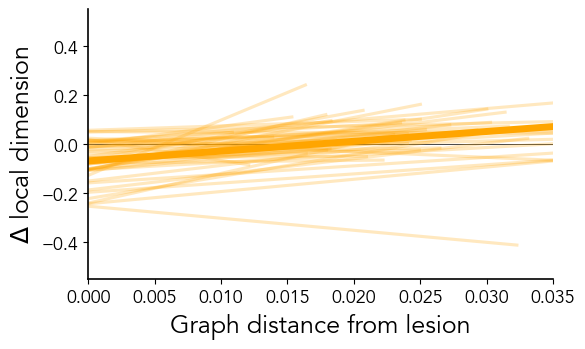

In [19]:
ax = plt.subplot(1, 1, 1)

xmin, xmax = linear['graph_distance'].values.min(), linear['graph_distance'].values.max()
ymin, ymax = linear['delta_dim'].values.min(), linear['delta_dim'].values.max()
xrange = np.linspace(xmin, xmax, 100, endpoint=True)
yrange = np.linspace(ymin, ymax, 100, endpoint=True)

b_group = 0.01094
m_group = 0.13906

for subj in np.unique(linear['sub'].values):
    #extract data
    val_to_fit = linear.loc[linear['sub']==subj]
    x, y = val_to_fit['graph_distance'].values, val_to_fit['delta_dim'].values
    
    # linear fit
    m,b = np.polyfit(x, y, 1)
    
    # plot
    #plt.plot(xrange, m*xrange+b, c=cs[1], alpha=0.25)
    sns.regplot(x=x, y=y, ax=ax, scatter=False, color=cs[1], line_kws={'alpha': 0.25}, ci=None)
    
y_tilde = np.mean(linear['delta_dim']) + np.std(linear['delta_dim'])*( m_group*(xrange-np.mean(linear['graph_distance']))/np.std(linear['graph_distance']) + b_group )
    
plt.plot(xrange, y_tilde, c=cs[1], lw=5)

#sns.scatterplot(data=linear, x='distance', y='delta_dim', hue='sub', ax=ax)
ax.set_xlabel('Graph distance from lesion')
ax.set_ylabel(r'$\Delta$ local dimension')
ax.set_ylim(-0.55, 0.55)
ax.set_xlim(None, 0.035)
plt.axhline(0, c='k', lw=0.5, zorder=-1)
sns.despine(ax=ax)

In [669]:
import pingouin as pg

In [680]:
df = pd.DataFrame(np.stack([1-ress_control[:,2], ress_control[:,0], dim_control]).T, columns=['integration', 'degree', 'dim'] )
pg.partial_corr(data=df, x='integration', y='dim', covar='degree')

,n,r,CI95%,p-val
pearson,29,0.940601,"[0.87, 0.97]",1.040429e-13


In [681]:
df = pd.DataFrame(np.stack([1-ress_stroke[:,2], ress_stroke[:,0], dim_stroke]).T, columns=['integration', 'degree', 'dim'] )
pg.partial_corr(data=df, x='integration', y='dim', covar='degree')

,n,r,CI95%,p-val
pearson,50,0.948664,"[0.91, 0.97]",3.883137e-25


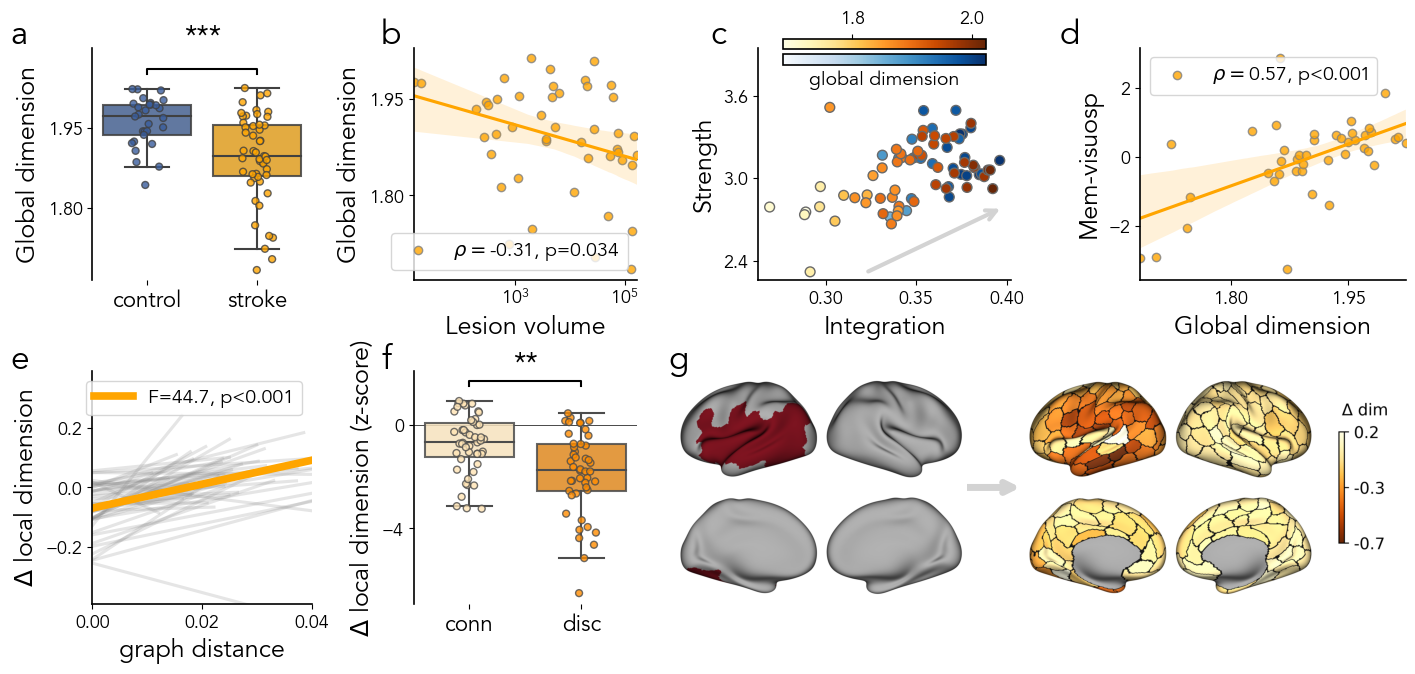

In [66]:
### Global info
figsize=(14,6.5)
nrows = 3
ncols = 12
height_ratios = [2, 1, 1]
width_ratios = [1] * ncols
#width_ratios[0] = 1.6
title_size = 24
ylabel_size = 20
offset = 10
letter_size = 24
legend_size = 14
pad_cbar_1 = .025
pad_cbar_2 = -1.4
shrink = 0.8
fontsize_annot = 20

### Generate figure
fig = plt.figure(figsize=figsize, layout='constrained')
gs = GridSpec(nrows, ncols, figure=fig, height_ratios=height_ratios, width_ratios=width_ratios)

### Boxplot dimension
ax = fig.add_subplot(gs[0, 0:3])
x = 'name'
y = 'dim_avg'
hue = None
df = ress
sns.boxplot(data=df, x=x, y=y, hue=hue, palette=cs, boxprops={'alpha': 0.85}, fliersize=0, ax=ax)
sns.stripplot(data=df, x=x, y=y, hue=hue, palette=cs, ax=ax, dodge=True, alpha=0.8, jitter=0.15, edgecolor='gray', linewidth=1)
sns.despine(ax=ax, bottom=True)
plt.ylabel('Global dimension')
plt.xlabel('')
plt.xticks(fontsize=ylabel_size-4)
ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
starbars.draw_annotation([('control', 'stroke', 1e-3)], ax=ax, fontsize=fontsize_annot)
plt.ylim(None, 2.099)

### Lesion size
ax = fig.add_subplot(gs[0, 3:6])

x = subset_merged['lesion_volume'].values
y = subset_merged['dim'].values
rho, pval = pearsonr(np.log(x), y)
label = r'$\rho=$'+str(round(rho,2))+', p='+str(round(pval, 3))

sns.regplot(data=subset_merged, x=x, y=y, logx=True, color=cs[1], label=label, ax=ax, scatter_kws={"edgecolor": "gray", 'linewidth':1})
ax.set(xscale='log')
ax.set_xlabel('Lesion volume')
ax.set_ylabel('Global dimension')
sns.despine(ax=ax)
ax.legend(prop={'size':legend_size})
#ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

### Topological features
ax = fig.add_subplot(gs[0, 6:9])
lw = 1
s = 50
vmin = np.min(np.concatenate([dim_control, dim_stroke]))
vmax = np.max(np.concatenate([dim_control, dim_stroke]))

im = ax.scatter(1-ress_control[:,2], ress_control[:,0], ec='dimgray', lw=lw, s=s, c=dim_control, vmin=vmin, vmax=vmax, cmap='Blues')
cbar = fig.colorbar(im, ax=ax, pad=pad_cbar_1, orientation="horizontal", shrink=shrink)
cbar.set_ticks([])
cbar.set_label('global dimension', size=14)

im = ax.scatter(1-ress_stroke[:,2], ress_stroke[:,0], ec='dimgray', lw=lw, s=s, c=dim_stroke, vmin=vmin, vmax=vmax, cmap='YlOrBr')
cbar = fig.colorbar(im, ax=ax, pad=pad_cbar_2, orientation="horizontal", shrink=shrink)
cbar.ax.xaxis.set_ticks_position("top")
#cbar.set_ticks([])

#sns.regplot(x=1-ress_control[:,2], y=ress_control[:,0], color=cs[0], ax=ax, scatter_kws={"edgecolor": "gray", 'linewidth':1}, scatter=False)
#sns.regplot(x=1-ress_stroke[:,2], y=ress_stroke[:,0], color=cs[1], ax=ax, scatter_kws={"edgecolor": "gray", 'linewidth':1}, scatter=False)

ax.set_ylabel('Strength')
ax.set_xlabel('Integration')
ax.set_ylim(None,3.95)
sns.despine(ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
#plt.legend()

#print('Control - Degree:', pearsonr(dim_control, ress_control[:,0]), ', Integration:', pearsonr(dim_control, 1-ress_control[:,2]))
#print('Stroke - Degree:', pearsonr(dim_stroke, ress_stroke[:,0]), ', Integration:', pearsonr(dim_stroke, 1-ress_stroke[:,2]))

# Add arrow
x0, y0, dx, dy = 0.32,2.3,0.4,2.8
# Draw arrow
ax.annotate('', (x0, y0), (dx, dy), ha="right", va="center",
            arrowprops=dict(arrowstyle='<-',shrinkA=5,shrinkB=5,fc="gray", ec="lightgray", linewidth=3))

### Behavior
ax = fig.add_subplot(gs[0, 9:12])
data_stroke = ress.loc[ress['name'] == 'stroke'].dropna()
x = 'dim_avg'
x = data_stroke[x].values
factor = 'Mem-visuosp'
y = data_stroke[factor].values
rho, pval = pearsonr(x, y)
if pval<1e-3: label = r'$\rho=$'+str(round(rho,2))+', p<0.001'
else: label = r'$\rho=$'+str(round(rho,2))+', p='+str(round(pval, 3))
sns.regplot(x=x, y=y, label=label, color=cs[1], scatter_kws={"edgecolor": "gray", 'linewidth':1})
plt.legend(prop={'size':legend_size})
plt.ylabel(factor)
plt.xlabel('Global dimension')
sns.despine(ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
#ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

### Correlation w distance
ax = fig.add_subplot(gs[1:,0:3])

xmin, xmax = linear['graph_distance'].values.min(), linear['graph_distance'].values.max()
ymin, ymax = linear['delta_dim'].values.min(), linear['delta_dim'].values.max()
xrange = np.linspace(xmin, xmax, 100, endpoint=True)
yrange = np.linspace(ymin, ymax, 100, endpoint=True)

b_group = 0.01094
m_group = 0.13906

for subj in np.unique(linear['sub'].values):
    #extract data
    val_to_fit = linear.loc[linear['sub']==subj]
    x, y = val_to_fit['graph_distance'].values, val_to_fit['delta_dim'].values
    
    # plot
    sns.regplot(x=x, y=y, ax=ax, scatter=False, color='gray', line_kws={'alpha': 0.2}, ci=None)
    
y_tilde = np.mean(linear['delta_dim']) + np.std(linear['delta_dim'])*( m_group*(xrange-np.mean(linear['graph_distance']))/np.std(linear['graph_distance']) + b_group )
    
plt.plot(xrange, y_tilde, c=cs[1], lw=5.5, label='F=44.7, p<0.001')

#sns.scatterplot(data=linear, x='distance', y='delta_dim', hue='sub', ax=ax)
ax.set_xlabel('graph distance')
ax.set_ylabel(r'$\Delta$ local dimension')
ax.set_ylim(-0.39, 0.39)
ax.set_xlim(0, 0.0401)
#ax.axhline(0, c='k', lw=0.4, zorder=-1)
sns.despine(ax=ax)
plt.legend()

### Boxplot dimension reduction - connected vs disconnected
ax = fig.add_subplot(gs[1:,3:6])

x = 'type'
y = 'z_score'
hue = None
df = ress

cs_disc = ['moccasin', 'darkorange']

sns.boxplot(data=df_disc, x=x, y=y, hue=hue, palette=cs_disc, boxprops={'alpha': 0.85}, fliersize=0, ax=ax)
sns.stripplot(data=df_disc, x=x, y=y, hue=hue, palette=cs_disc, ax=ax, dodge=True, alpha=0.8, jitter=0.15, edgecolor='gray', linewidth=1)
sns.despine(ax=ax, bottom=True)
plt.ylabel(r'$\Delta$ local dimension (z-score)')
plt.xlabel('')
plt.xticks(fontsize=ylabel_size-4)
ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
ax.axhline(0, c='k', lw=0.5, zorder=-1)
starbars.draw_annotation([('conn', 'disc', 0.006)], ax=ax, fontsize=fontsize_annot)
plt.ylim(None, 2.099)

# Add fake title
ax = fig.add_subplot(gs[1:,8:9])
#plt.axis('off')
ax.yaxis.set_visible(False)
#ax.xaxis.set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.set_xticklabels([])
sns.despine(ax=ax,bottom=True, left=True)
#ax.set_xlabel(f'Subj {subj_id}', size=ylabel_size)

############ Plot arrow ############
ax = fig.add_subplot(gs[1:,7:10])

x0, y0, dx, dy = 0.25,0.5,0.55,0.5
h0 = -1
l0 = 0.5
# Draw arrow
ax.annotate('', (x0, y0), (dx, dy), ha="right", va="center",
            arrowprops=dict(arrowstyle='<-',shrinkA=5,shrinkB=5,fc="gray", ec="lightgray", linewidth=5))
ax.axis('off')
plt.ylim(None, 1)

### Delta dim
subj_id = 277

ax = fig.add_subplot(gs[1:,5:9])
img = np.asarray(Image.open(folder_figures+f'fig_lesion_sub-{subj_id}_N_{parc}.png'))
ax.imshow(img)
plt.axis('off')
#ax.set_ylabel('Lesion mask')
#plt.title(f'Subj {subj_id}', size=ylabel_size)

ax = fig.add_subplot(gs[1:,8:])
img = np.asarray(Image.open(folder_figures+f'fig_dim_delta_sub-{subj_id}_N_{parc}.png'))
ax.imshow(img)
plt.axis('off')
#plt.title(f'Subj {subj_id}', size=ylabel_size)

### Add letters
ax = plt.gca()
h0, h1 = .96, 0.46
l0, l1, l2, l3 = 0.0, 0.265, 0.5, 0.75
l4, l5 = 0.3, 0.47

fig.text(l0,h0, 'a', size=letter_size)
fig.text(l1,h0, 'b', size=letter_size)
fig.text(l2,h0, 'c', size=letter_size)
fig.text(l3,h0, 'd', size=letter_size)
fig.text(l0,h1, 'e', size=letter_size)
fig.text(l1,h1, 'f', size=letter_size)
fig.text(l5,h1, 'g', size=letter_size)

#plt.subplots_adjust(hspace=0.7, wspace=0.7)
plt.savefig(folder_figures+'fig4.png', dpi=200, bbox_inches='tight')
plt.show()

In [136]:
### Compute delta-dim map
for idx, subj in enumerate(dim_stroke_names):
    # Compute delta
    delta = dim_stroke_local[idx] - dim_controls_local.mean(axis=0)
    fname = 'delta_dim_'+subj+f'_parc_{parc}.npy'
    np.save(directory+fname, delta)

# Criticality

In [11]:
def create_disconnected_graph():

    l = [np.arange(7), np.arange(7,15), np.arange(15,18)]
    k = [np.arange(7), np.arange(7,15), np.arange(15,18)]

    G = nx.compose_all(map(nx.path_graph, l))
    K = nx.compose_all(map(nx.complete_graph, k))

    mapping = dict(zip(K, np.arange(18, 36)))
    G = nx.relabel_nodes(G, mapping)

    G = nx.compose(G, K)
    
    #nx.draw(G)
    #plt.show()

    return G

In [12]:
# Expand pandas dataframe
tmp = ress.copy().explode('crit_all')

tmp['T'] = np.array( [tt[0] for tt in tmp['crit_all'].values] )
tmp['A'] = np.array( [tt[1] for tt in tmp['crit_all'].values] )
tmp['sigma'] = np.array( [tt[2] for tt in tmp['crit_all'].values] )
tmp['S1'] = np.array( [tt[3] for tt in tmp['crit_all'].values] )
tmp['S2'] = np.array( [tt[4] for tt in tmp['crit_all'].values] )

tmp = tmp.drop(columns=['crit_all', 'crit_all', 'dim_all', 'dim_avg'])

df_crit_extended = tmp.copy()

### Relation btw dimension and criticality
tmp = ress.copy()

crit_vals = tmp['crit_all'].values

new_columns = np.zeros((len(crit_vals), 4))

for idx, tmp_tt in enumerate(crit_vals):
    new_columns[idx] = tmp_tt[:,2].max(), tmp_tt[:,4].max(), tmp_tt[:,2].sum(), tmp_tt[:,4].sum()
    
df_new = pd.DataFrame(new_columns, columns=['sigma_max', 'S2_max', 'sigma_sum', 'S2_sum'])
df_new = df_new.set_index(tmp.index)

tmp = pd.concat([tmp, df_new], axis=1, ignore_index=False)

tmp = tmp.drop(columns=['dim_all', 'crit_all'])

df_crit_dim = tmp.copy()

In [13]:
### Create networks
nets_to_show = []
pos_nets = []

# Fully-connected
nn = 10
G = nx.complete_graph(nn)
pos = nx.circular_layout(G)
nets_to_show.append(G)
pos_nets.append(pos)

# Connectome
mat = control.load_matrix(0)
#mat[mat<np.max(mat)/100] = 0
mat[mat<np.median(mat)] = 0
G = nx.from_numpy_array(mat)
pos = control.get_rois()[['A', 'S']].values
nets_to_show.append(G)
pos_nets.append(pos)

# Disconnected
G = create_disconnected_graph()
pos = nx.spring_layout(G, k=0.2, iterations=20, seed=20)
nets_to_show.append(G)
pos_nets.append(pos)

- Loading sub-040


In [17]:
### Simulate HTC
N = parc
# Define params
r1 = 2/N
r2 = 100/N

Tmin, Tmax, Tplus, Tminus = HTC.get_Trange(r1, r2, c_min=0., c_max = 1.)

steps = int(1e4)
eq_steps = int(5e3)
runs = 10
nT = 30 #nT = 30

### Re-create networks
print('Generate networks...')
nets = []

# Fully-connected
G = nx.complete_graph(N)
pos = nx.circular_layout(G)
nets.append(G)

# Connectome
mat = control.load_matrix(0)
mat[mat<np.median(mat)] = 0
G = nx.from_numpy_array(mat)
pos = rois[['A', 'S']].values
nets.append(G)

# Sparse
G = nx.watts_strogatz_graph(N, k=2, p=0.1)
while not nx.is_connected(G):
    G = nx.watts_strogatz_graph(N, k=2, p=0.1)
pos = nx.spring_layout(G, k=0.2, iterations=20, seed=20)
nets.append(G)

### Simulate
print('Simulate HTC...')
tmp_ress_htc = []
for G in nets:
    W = nx.to_numpy_array(G)
    
    tmp_htc = HTC.run_htc(W, r1, r2, Tmin, Tmax, nT, steps, eq_steps, runs, step_clust=0,
                  norm=True, Tdiv_log=False, display=True, hysteresis=True, num_threads=4)
    tmp_ress_htc.append(tmp_htc)

r1=0.01, r2=0.5
Tminus=0.009708737864077669, Tplus=0.25
Tmin=0.0, Tmax=0.25
Generate networks...
- Loading sub-040
Simulate HTC...
1/59 - T = 0.0 * T+
2/59 - T = 0.03 * T+
3/59 - T = 0.07 * T+
4/59 - T = 0.1 * T+
5/59 - T = 0.14 * T+
6/59 - T = 0.17 * T+
7/59 - T = 0.21 * T+
8/59 - T = 0.24 * T+
9/59 - T = 0.28 * T+
10/59 - T = 0.31 * T+
11/59 - T = 0.34 * T+
12/59 - T = 0.38 * T+
13/59 - T = 0.41 * T+
14/59 - T = 0.45 * T+
15/59 - T = 0.48 * T+
16/59 - T = 0.52 * T+
17/59 - T = 0.55 * T+
18/59 - T = 0.59 * T+
19/59 - T = 0.62 * T+
20/59 - T = 0.66 * T+
21/59 - T = 0.69 * T+
22/59 - T = 0.72 * T+
23/59 - T = 0.76 * T+
24/59 - T = 0.79 * T+
25/59 - T = 0.83 * T+
26/59 - T = 0.86 * T+
27/59 - T = 0.9 * T+
28/59 - T = 0.93 * T+
29/59 - T = 0.97 * T+
30/59 - T = 1.0 * T+
31/59 - T = 0.97 * T+
32/59 - T = 0.93 * T+
33/59 - T = 0.9 * T+
34/59 - T = 0.86 * T+
35/59 - T = 0.83 * T+
36/59 - T = 0.79 * T+
37/59 - T = 0.76 * T+
38/59 - T = 0.72 * T+
39/59 - T = 0.69 * T+
40/59 - T = 0.66 * T+
41/

In [18]:
# Example of trajectory at critical point for large and low dim
idx_control_max = np.argsort(ress[ress['name']=='control']['dim_avg'].values)#.argmax()
idx_stroke_min = np.argsort(ress[ress['name']=='stroke']['dim_avg'].values)#.argmin()

idx_control_traj = idx_control_max[1]
idx_stroke_traj = idx_stroke_min[-1]

In [19]:
### Define params
# Define params
r1 = 1/N
r2 = 100/N
T = 0.16
x0 = HTC.init_state(N, 1/3, 1/3)

trajs = []

### Load matrix
mat = control.load_matrix(idx_control_traj)
tmp_traj = HTC.simulate_trajectory(HTC.normalize(mat), T, r1, r2, steps, eq_steps, x0)
trajs.append((tmp_traj[2]==1).astype(int))

# Simulate HTC
mat = stroke.load_matrix(idx_stroke_traj)
tmp_traj = HTC.simulate_trajectory(HTC.normalize(mat), T, r1, r2, steps, eq_steps, x0)
trajs.append((tmp_traj[2]==1).astype(int))

- Loading sub-063
- Loading sub-250


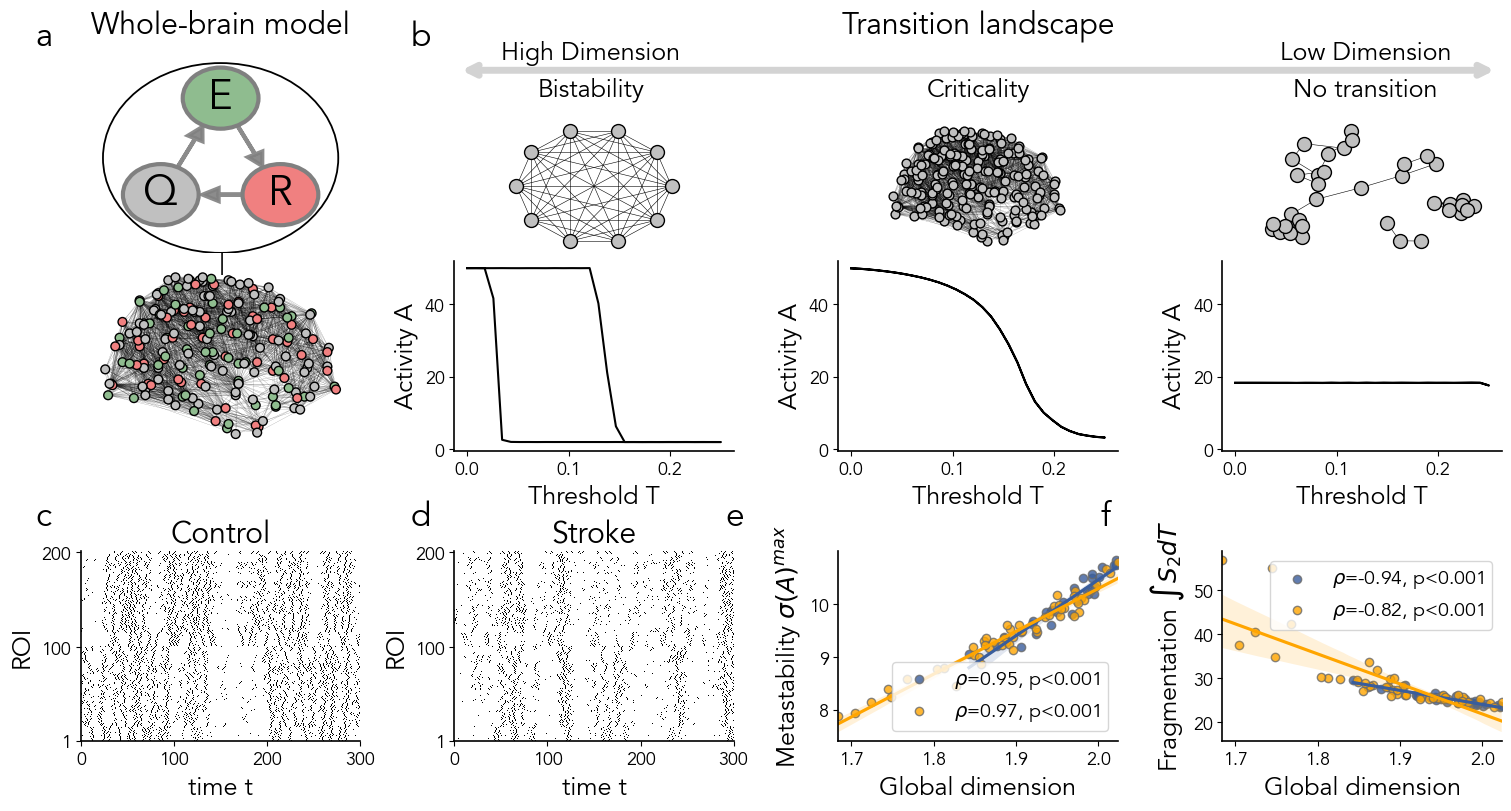

In [25]:
import matplotlib.transforms as mtransforms

### Global info
figsize = (15,8)
nrows = 4
ncols = 4
height_ratios = [0.3,0.7,1,1]
width_ratios = [1,1,1,1]
title_size = 24
ylabel_size = 20
offset = 10
letter_size = 24
legend_size = 14

node_color = 'silver'
edgecolors = 'k'
node_size = [100, 40, 100]
edgewidth = [0.4, 0.08, 0.4]

max_steps = 300

### Generate figure
fig = plt.figure(figsize=figsize, layout='constrained')
gs = GridSpec(nrows, ncols, figure=fig, height_ratios=height_ratios, width_ratios=width_ratios)

### HTC model
ax = fig.add_subplot(gs[0:2,0])
ax.set_title('Whole-brain model')

# Draw circles
radius = 0.2
pos_circles = [(radius,radius), (1-radius, radius), (0.5, 1-radius)]
color_circles = ['silver', 'lightcoral', 'darkseagreen']#['silver', cs[0], cs[1]]
text_circles = ['Q', 'R', 'E']

for crc in range(3):
    circle = plt.Circle(pos_circles[crc], radius*0.95, zorder=2,
                        facecolor=color_circles[crc], alpha=1, edgecolor="gray", linewidth=3)
    ax.add_patch(circle)
    ax.text(pos_circles[crc][0], pos_circles[crc][1], text_circles[crc], fontsize=30, color='k', zorder=3, horizontalalignment='center', verticalalignment='center')
ax.axis('off')
ax.set_xlim(-.2,1.2)
ax.set_ylim(-.16,1.15)

# Draw large circle
circle = plt.Circle((0.5,0.428), 0.59, zorder=0, facecolor='white', alpha=1, edgecolor="k", linewidth=1.3)
ax.add_patch(circle)

# Draw arrows
head_width = 0.08
head_length = 1 * head_width

l = 0.39

alpha = np.pi / 2 / np.sqrt(2)
x, y, dx, dy = pos_circles[0][0], pos_circles[0][1], l*np.cos(alpha), l*np.sin(alpha) #0.14, 0.35
ax.arrow(x, y, dx, dy, zorder=1, lw=3, facecolor='gray', edgecolor='gray', head_width=head_width, head_length=head_length, alpha=0.9)

alpha = -np.pi / 2 / np.sqrt(2)
x, y, dx, dy = pos_circles[2][0], pos_circles[2][1], l*np.cos(alpha), l*np.sin(alpha) #0.14, 0.35
ax.arrow(x, y, dx, dy, zorder=1, lw=3, facecolor='gray', edgecolor='gray', head_width=head_width, head_length=head_length, alpha=0.9)

l = 0.31
alpha = np.pi
x, y, dx, dy = pos_circles[1][0], pos_circles[1][1], l*np.cos(alpha), l*np.sin(alpha) #0.14, 0.35
ax.arrow(x, y, dx, dy, zorder=1, lw=3, facecolor='gray', edgecolor='gray', head_width=head_width, head_length=head_length, alpha=0.9)

### Connectome w HTC model
ax = fig.add_subplot(gs[2,0])
idx = 1
tmp_colors = np.zeros(N).astype(str)
tmp_colors[:N//4] = rgb2hex(color_circles[2])
tmp_colors[N//4:N//2] = rgb2hex(color_circles[1])
tmp_colors[N//2:] = color_circles[0]
np.random.shuffle(tmp_colors)
nx.draw(nets_to_show[idx], ax=ax, pos=pos_nets[idx], node_color=tmp_colors, edgecolors=edgecolors, width=edgewidth[idx], node_size=node_size[idx])

### Arrow w text
x0, y0, dx, dy = 0,0,1,0
h0, h1 = 0.3, -0.35
l0, l1, l2 = 0.13, 0.5, 0.87
ax = fig.add_subplot(gs[0,1:])
# Draw arrow
ax.annotate('', (x0, y0), (dx, dy), ha="right", va="center",
            arrowprops=dict(arrowstyle='<->',shrinkA=5,shrinkB=5,fc="gray", ec="lightgray", linewidth=5))
# Draw texts
ax.text(l0,h0,'High Dimension', horizontalalignment='center', verticalalignment='center')
ax.text(l2,h0,'Low Dimension', horizontalalignment='center', verticalalignment='center')
ax.text(l0,h1,'Bistability', horizontalalignment='center', verticalalignment='center')
ax.text(l1,h1,'Criticality', horizontalalignment='center', verticalalignment='center')
ax.text(l2,h1,'No transition', horizontalalignment='center', verticalalignment='center')
ax.set_ylim(-0.5,0.5)
plt.axis('off')
ax.set_title('Transition landscape')

### Networks
ax_names = ['b', 'c', 'd']
xlims = [(-1.8,1.8), (-150,120), (-1,1)]

for idx, tmp in enumerate(ax_names):
    ax = fig.add_subplot(gs[1,idx+1])
    nx.draw(nets_to_show[idx], ax=ax, pos=pos_nets[idx], node_color=node_color, edgecolors=edgecolors, width=edgewidth[idx], node_size=node_size[idx])
    #plt.axis('on')
    #ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_xlim(xlims[idx])
    
### Transition type
for idx, tmp in enumerate(ax_names):
    ax = fig.add_subplot(gs[2,idx+1])
    ax.plot(tmp_ress_htc[idx][0], tmp_ress_htc[idx][1], c='k')
    ax.set_xlabel('Threshold T')
    ax.set_ylabel('Activity A')
    ax.set_ylim(-0.4, 52)
    sns.despine(ax=ax)

### Example of trajectories
# Control
ax = fig.add_subplot(gs[3,0])
ax.pcolormesh(trajs[0][-max_steps:].T, cmap='gray_r')
ax.set_title('Control')
ax.set_xlabel('time t')
ax.set_ylabel('ROI')
ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
ax.set_yticks([0,99,199],[1,100,200])
sns.despine(ax=ax)

# Stroke
ax = fig.add_subplot(gs[3,1])
ax.pcolormesh(trajs[1][-max_steps:].T, cmap='gray_r')
ax.set_title('Stroke')
ax.set_xlabel('time t')
ax.set_ylabel('ROI')
ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
ax.set_yticks([0,99,199],[1,100,200])
sns.despine(ax=ax)

### Altered criticality
# sigma
ax = fig.add_subplot(gs[3,2])

x = 'dim_avg'
y = 'sigma_max'
xlabel = 'Global dimension'
ylabel = r'Metastability $\sigma(A)^{max}$'

subs = df_crit_dim.loc[df_crit_dim['name']=='control']
rho, pval = pearsonr(subs[x], subs[y])
if pval<1e-3: label = r'$\rho$='+str(round(rho, 2)) + ', p<0.001'
else: label = r'$\rho$='+str(round(rho, 2)) + ', p='+str(round(pval, 3))
sns.regplot(data=subs, x=x, y=y, color=cs[0], scatter_kws={'ec': 'dimgray'}, ax=ax, label=label)
subs = df_crit_dim.loc[df_crit_dim['name']=='stroke']
rho, pval = pearsonr(subs[x], subs[y])
if pval<1e-3: label = r'$\rho$='+str(round(rho, 2)) + ', p<0.001'
else: label = r'$\rho$='+str(round(rho, 2)) + ', p='+str(round(pval, 3))
sns.regplot(data=subs, x=x, y=y, color=cs[1], scatter_kws={'ec': 'dimgray'}, ax=ax, label=label)
ax.legend()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
sns.despine(ax=ax)

# S2
ax = fig.add_subplot(gs[3,3])

x = 'dim_avg'
y = 'S2_sum'
xlabel = 'Global dimension'
ylabel = r'Fragmentation $\int S_2 dT$'

subs = df_crit_dim.loc[df_crit_dim['name']=='control']
rho, pval = pearsonr(subs[x], subs[y])
if pval<1e-3: label = r'$\rho$='+str(round(rho, 2)) + ', p<0.001'
else: label = r'$\rho$='+str(round(rho, 2)) + ', p='+str(round(pval, 3))
sns.regplot(data=subs, x=x, y=y, color=cs[0], scatter_kws={'ec': 'dimgray'}, ax=ax, label=label)
subs = df_crit_dim.loc[df_crit_dim['name']=='stroke']
rho, pval = pearsonr(subs[x], subs[y])
if pval<1e-3: label = r'$\rho$='+str(round(rho, 2)) + ', p<0.001'
else: label = r'$\rho$='+str(round(rho, 2)) + ', p='+str(round(pval, 3))
sns.regplot(data=subs, x=x, y=y, color=cs[1], scatter_kws={'ec': 'dimgray'}, ax=ax, label=label)
ax.legend()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
sns.despine(ax=ax)

### Add letters
h0, h1 = .95, 0.35
l0, l1, l2, l3 = 0.02, 0.27, 0.48, 0.73

fig.text(l0,h0, 'a', size=letter_size)
fig.text(l1,h0, 'b', size=letter_size)
fig.text(l0,h1, 'c', size=letter_size)
fig.text(l1,h1, 'd', size=letter_size)
fig.text(l2,h1, 'e', size=letter_size)
fig.text(l3,h1, 'f', size=letter_size)

### Add arrow
ax = plt.gca()
fig.text(0.142, 0.665, '|', fontsize=20)

### Add titles
#ax = fig.add_subplot(gs[3,0:2])
#ax.set_title('Prova')
#ax.axis('off')

#plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig(folder_figures+'fig5.png', dpi=200, bbox_inches='tight')
plt.show()

# Figure framework

In [26]:
tmp_control = data_loader(which='control', ses=session, parc=100, include_subctx=False, thr='mask')

######## control - ses 01 - parc 100 - total 29 - thr mask - subctx False ########


- Loading sub-040


/home/barzon/Stroke_connectomes_analysis/utils/dyngdim/dyngdim.py:128: RuntimeWarning: Mean of empty slice
  local_dimensions.append(np.nanmean(relative_dimensions_reduced, axis=1))
/home/barzon/Stroke_connectomes_analysis/utils/dyngdim/plotting.py:273: RuntimeWarning: Mean of empty slice
  plt.plot(times, np.nanmean(local_dimensions, axis=1), 'o-', c='violet', zorder=-1)
/home/barzon/Stroke_connectomes_analysis/utils/dyngdim/plotting.py:287: RuntimeWarning: Mean of empty slice
  dim_avg = np.nanmean(local_dimensions, axis=1)
/home/barzon/Stroke_connectomes_analysis/utils/dyngdim/plotting.py:292: RuntimeWarning: Mean of empty slice
  plt.plot(times[imax], np.nanmean(local_dimensions, axis=1)[imax], 'o', c='red', label=r'D$_{max}$='+str(np.round(dim,2)))


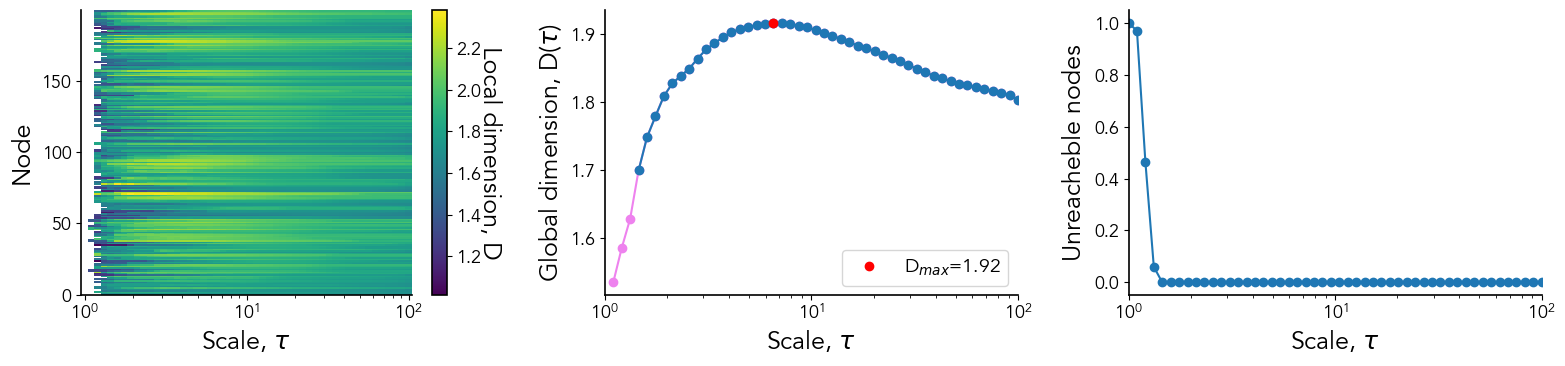

In [27]:
### Compute dimension for one example
t_min = 0
t_max = 2
n_t = 50
n_workers = 25

times = np.logspace(t_min, t_max, n_t)

mat = control.load_matrix(0)
    
mat /= mat.max()
local_dimensions = dyngdim.run_local_dimension(nx.from_numpy_array(mat), times, n_workers=n_workers, use_spectral_gap=False)
    
dim, dim_all = plot_results(times, local_dimensions, mat)

- Loading sub-040


/tmp/ipykernel_119142/1652540176.py:55: RuntimeWarning: Mean of empty slice
  idx_max = np.nanargmax(np.nanmean(local_dimensions, axis=1))
/tmp/ipykernel_119142/1652540176.py:73: RuntimeWarning: Mean of empty slice
  ax.plot(times, np.nanmean(local_dimensions, axis=1), c='darkblue', lw=3)
/tmp/ipykernel_119142/1652540176.py:74: RuntimeWarning: Mean of empty slice
  ax.scatter(times[idx_max], np.nanmean(local_dimensions, axis=1)[idx_max], s=50, c='orange', zorder=4)


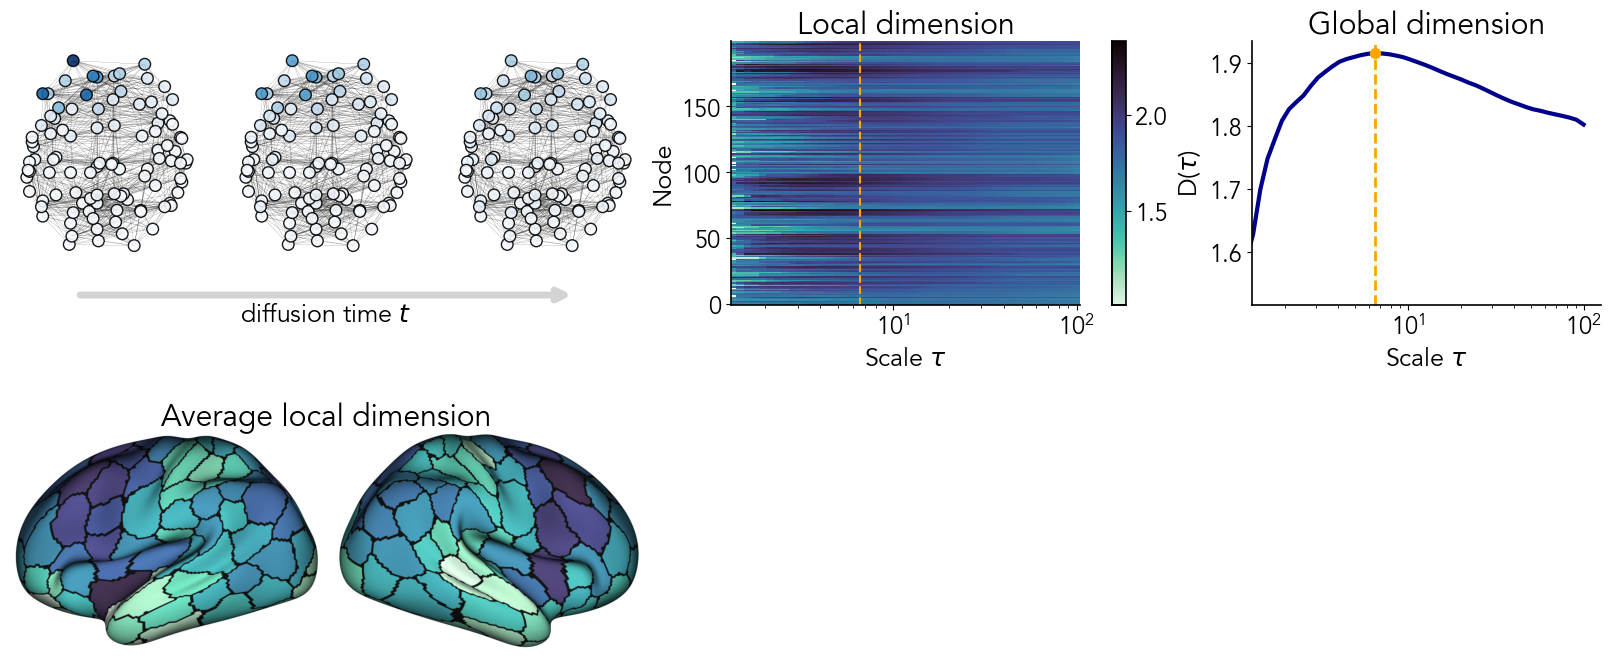

In [29]:
figsize = (16,7)
nrows = 4
ncols = 5
height_ratios = [1, 0.9, 0.1, 3]
width_ratios = [1, 1, 1, 1.8, 1.8]

plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 17

############ Generate figure ############
fig = plt.figure(figsize=figsize, layout='constrained') #
gs = GridSpec(nrows, ncols, figure=fig, height_ratios=height_ratios, width_ratios=width_ratios)

############ Plot networks ############
node_id = 44 #35#29
taus = np.array( [1, 1.7, 3] ) * 2.9
#taus = [0.1, 0.5, 0.9]
node_color = 'gray'
node_size = 70
edge_width = 0.1

# Load matrix
W = tmp_control.load_matrix(0)
L = np.eye(W.shape[0]) - HTC.normalize(W)
#L = np.diag( W.sum(axis=1) ) - W
#L = L / L.max()

# Compute propagators
states = [expm(-L*tau)[node_id] for tau in taus]

for idx, tau in enumerate(taus):
    ax = fig.add_subplot(gs[:2,idx])
    
    propagator = expm(-L*tau)
    nx.draw(nx.from_numpy_array(W), ax=ax, pos=tmp_control.get_rois()[['R','A']].values, node_color=states[idx], edgecolors='k', width=edge_width, node_size=node_size,
            vmin=0, vmax=np.max(states), cmap='Blues', alpha=.9)
    
############ Plot arrow ############
ax = fig.add_subplot(gs[2,:len(taus)])

x0, y0, dx, dy = 0.1,0.9,0.9,0.9
h0 = -1
l0 = 0.5
# Draw arrow
ax.annotate('', (x0, y0), (dx, dy), ha="right", va="center",
            arrowprops=dict(arrowstyle='<-',shrinkA=5,shrinkB=5,fc="gray", ec="lightgray", linewidth=5))
ax.axis('off')
plt.ylim(None, 1)

# Draw texts
ax.text(l0,h0,r'diffusion time $t$', horizontalalignment='center', verticalalignment='center')

############ Plot local dimension ############
idx_max = np.nanargmax(np.nanmean(local_dimensions, axis=1))

ax = fig.add_subplot(gs[0:3,len(taus)])
plt.pcolormesh(times, np.arange(parc), local_dimensions.T, cmap='mako_r')
plt.axvline(times[idx_max], c='orange', ls='--')
plt.xlabel(r'Scale $\tau$')
plt.ylabel('Node')
plt.xscale('log')
cbar = plt.colorbar(orientation='vertical')
#cbar.ax.set_ylabel(r'Local dimension D$_i(\tau)$', rotation=270)
#cbar.ax.set_xlabel(r'Local dimension D$_i(\tau)$', rotation=0)
#cbar.ax.get_yaxis().labelpad = 15
sns.despine()
plt.xlim(1.3)
plt.title('Local dimension')

############ Plot global dimension ############
ax = fig.add_subplot(gs[0:3,len(taus)+1])
ax.plot(times, np.nanmean(local_dimensions, axis=1), c='darkblue', lw=3)
ax.scatter(times[idx_max], np.nanmean(local_dimensions, axis=1)[idx_max], s=50, c='orange', zorder=4)
plt.axvline(times[idx_max], c='orange', ls='--', lw=2)
#ax2.set_ylabel(r'Global dimension D($\tau$)')
plt.xlabel(r'Scale $\tau$')
ax.set_ylabel(r'D($\tau$)')
plt.title('Global dimension')
plt.xscale('log')
plt.xlim(1.3)
sns.despine()

############ Average control global dimension ############
ax = fig.add_subplot(gs[3,:3])
img = np.asarray(Image.open(folder_figures+f'fig_dim_local_avg_N_{parc}.png'))
ax.imshow(img[100:img.shape[0]//2-50,60:-350])
plt.axis('off')
plt.title('Average local dimension')

############ Morphospace ############
'''
ax = fig.add_subplot(gs[3,3:5])

xmin, xmax = 1, 4
ymin, ymax = 1, 4
xx = np.arange(xmin,xmax)
yy = np.arange(ymin,ymax)
mat = yy.reshape(-1,1)@xx.reshape(-1,1).T
mat = mat**(1/3)
im = ax.pcolormesh(xx, yy, mat, shading='gouraud', cmap='mako_r', alpha=1)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', ticks=[mat.min(), mat.max()])
cbar.ax.set_ylabel('network dimension')
cbar.ax.set_yticklabels(['0', r'$\infty$'])

xx = np.linspace(xmin,xmax-1, 100)
ax.plot(xx, 1/(xx-0.6)+1., c='k')
ax.plot(xx, 1/(xx-0.7)+1.2, c='k')

ax.set_xlabel('integration')
ax.set_ylabel('connectance')
ax.set_xlim()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(xmin, xmax-1)
ax.set_ylim(ymin, ymax-1)
ax.text(xmin+0.4, ymin+0.35, 'No transition')
ax.text(xmax-1.7, ymax-1.8, 'Discontinuous')
ax.text(xmin+0.92, ymin+0.75, 'Critical', rotation=-10)

plt.title('Morphospace')
'''
plt.savefig(folder_figures+'figure_framework_1.svg', transparent=True)
#plt.tight_layout()
#plt.subplots_adjust(hspace=1)
plt.show()

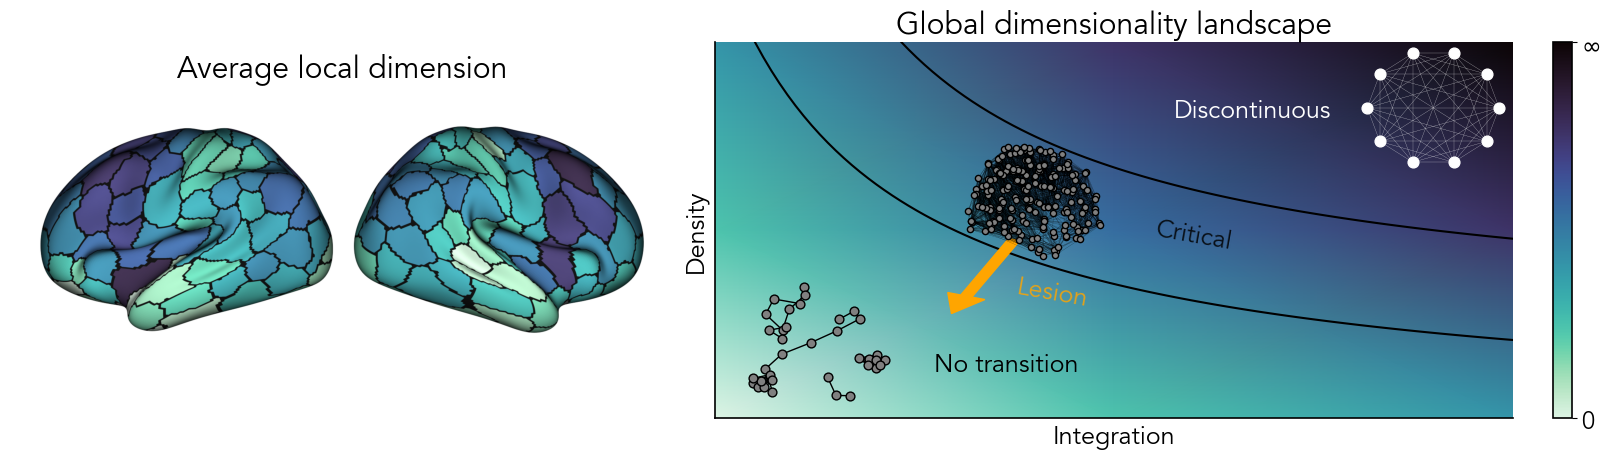

In [32]:
figsize = (16,7)
nrows = 4
ncols = 5
height_ratios = [1, 0.9, 0.1, 3]
width_ratios = [1, 1, 1, 1.8, 1.8]

plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 17

############ Generate figure ############
fig = plt.figure(figsize=figsize, layout='constrained') #
gs = GridSpec(nrows, ncols, figure=fig, height_ratios=height_ratios, width_ratios=width_ratios)

############ Average control global dimension ############
ax = fig.add_subplot(gs[3,:3])
img = np.asarray(Image.open(folder_figures+f'fig_dim_local_avg_N_{parc}.png'))
#ax.imshow(img[100:img.shape[0]//2-50,60:-350])
ax.imshow(img[:img.shape[0]//2+50,:-280])
plt.axis('off')
ax.set_title('Average local dimension')

# Draw arrows
'''
arrow_style = {
    "head_width": 50,
    "head_length": 50,
    "width": 3,
    "color":"k"
}

W, H = 0, -350 #-550
x0, y0 = 810, 500#620
plt.arrow(x=x0, y=y0, dx=W, dy=H, **arrow_style)
#ax.text(40, y0, 'ventral', rotation=0, c='k')
#ax.text(40, y0+H, 'dorsal', rotation=0, c='k')

W, H = -400, -120
x0, y0 = 1300, 650
plt.arrow(x=x0, y=y0, dx=W, dy=H, **arrow_style)
#ax.text(700, y0, 'high D', rotation=0, c='k')
#ax.text(1200, y0+50, 'low D', rotation=0, c='k')
'''

############ Morphospace ############
ax = fig.add_subplot(gs[3,3:5])
xmin, xmax = 1, 4
ymin, ymax = 1, 4
xx = np.arange(xmin,xmax)
yy = np.arange(ymin,ymax)
mat = yy.reshape(-1,1)@xx.reshape(-1,1).T
mat = mat**(1/3)
im = ax.pcolormesh(xx, yy, mat, shading='gouraud', cmap='mako_r', alpha=1, rasterized=True)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', ticks=[mat.min(), mat.max()])
#cbar.ax.set_ylabel('Global dimension')
cbar.ax.set_yticklabels(['0', r'$\infty$'])

xx = np.linspace(xmin,xmax-1, 100)
ax.plot(xx, 1/(xx-0.6)+1., c='k')
ax.plot(xx, 1/(xx-0.8)+1.5, c='k')
ax.set_xlabel('Integration')
ax.set_ylabel('Density')
ax.set_xlim()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(xmin, xmax-1)
ax.set_ylim(ymin, ymax-1)

ax.text(xmin+0.55, ymin+0.25, 'No transition')
ax.text(xmax-1.85, ymax-1.4, 'Discontinuous', c='white')
ax.text(xmin+1.1, ymin+0.9, 'Critical', rotation=-10, c='k', alpha=0.85)

plt.title('Global dimensionality landscape')

######### Add networks #########
node_colors = ['white', 'gray', 'gray']
edge_colors = ['white', 'k', 'k']
edge_widths = [0.15, 0.1, 1]
node_sizes = [60, 20, 40]

# Define position
width, height = 0.2, 0.35

pos_graphs = [[0.8,0.65], [0.3, 0.4], [0.03, 0.03]]
#left, bottom = 0.4, 0.4
#ax2 = axs[idx].inset_axes([left, bottom, width, height], transform=axs[idx].transData)

for idx, net in enumerate(nets_to_show):
    left, bottom = pos_graphs[idx]
    ax2 = ax.inset_axes([left, bottom, width, height])
    nx.draw(net, ax=ax2, pos=pos_nets[idx], node_color=node_colors[idx], edgecolors=edge_colors[idx], edge_color=edge_colors[idx], width=edge_widths[idx], node_size=node_sizes[idx])

# Draw arrow
W, H = -0.12, -0.3
arrow_style = {
    "head_width": 0.1,
    "head_length": 0.1,
    "width": 0.03,
    "color":"orange"
}

plt.arrow(x=xmin+0.75, y=ymin+0.95, dx=W, dy=H, **arrow_style, zorder=2)
ax.text(xmin+.75, ymin+0.6, 'Lesion', rotation=-10, c='orange', alpha=0.85)
    
#plt.savefig(folder_figures+'figure_framework.png') #background transparent
#plt.tight_layout()
#plt.subplots_adjust(hspace=1)
plt.savefig(folder_figures+'figure_framework_2.svg', transparent=True)
plt.show()